In [30]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import pathlib
from IPython import display
import os
import numpy as np
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
from torch import nn, optim
import seaborn as sns
from torchvision import datasets
import torchvision.utils as vutils
from tqdm.auto import tqdm
import torch.nn.functional as F

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
! nvidia-smi

cuda
Fri Jul  8 16:14:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   40C    P8     8W / 151W |   4322MiB /  8192MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

# Dataset

In [3]:
BATCH_SIZE = 50
IMG_SIZE = 32
cuda = True

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./mnist",
        train=False,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(IMG_SIZE), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
len(dataloader), len(dataloader_test)

(1200, 200)

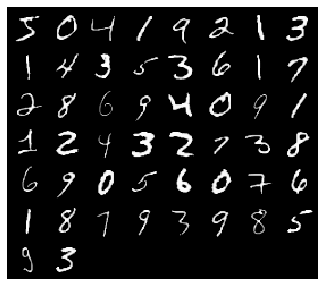

In [4]:
def show_batch(data_loader):
    for images, labels in data_loader:
        plt.subplots(figsize=(7, 5))
        plt.axis("off")
        plt.imshow(make_grid(images[:BATCH_SIZE], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(dataloader)

# SGAN

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(10, 100)

        self.init_size = IMG_SIZE // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = IMG_SIZE // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 10 + 1), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label
    
def evaluate(d):
    # Evaluation
    accs = []
    for i, (imgs, labels) in tqdm(enumerate(dataloader_test, 0), total=len(dataloader_test)):
        batch_size = imgs.shape[0]
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        real_imgs = Variable(imgs.type(FloatTensor))
        real_pred, real_aux = d(real_imgs)
        pred = real_aux.data.cpu().numpy()
        gt = labels.data.cpu().numpy()
        d_acc = np.mean(np.argmax(pred[:, :10], axis=1) == gt)
        accs.append(d_acc)
    print("Test Accuracy:", np.mean(accs))
    return np.mean(accs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 0/100] [D loss: 0.012585, acc: 10%] [G loss: 0.020098]


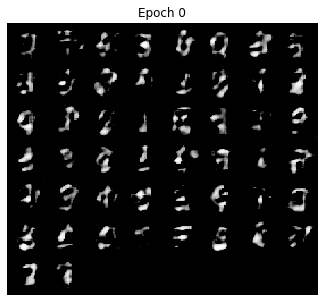

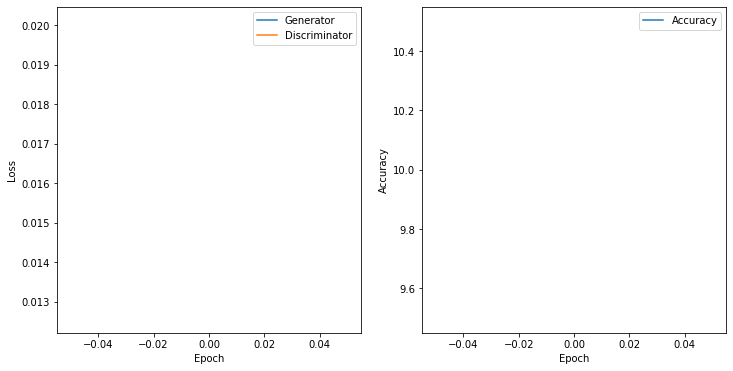

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.1011


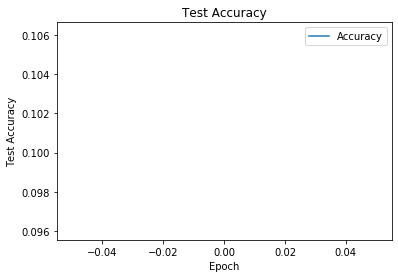

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 1/100] [D loss: 0.010453, acc: 10%] [G loss: 0.026907]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 2/100] [D loss: 0.008413, acc: 28%] [G loss: 0.036323]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 3/100] [D loss: 0.008409, acc: 34%] [G loss: 0.033277]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 4/100] [D loss: 0.007067, acc: 31%] [G loss: 0.036817]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 5/100] [D loss: 0.005519, acc: 43%] [G loss: 0.045967]


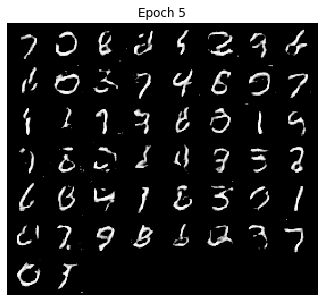

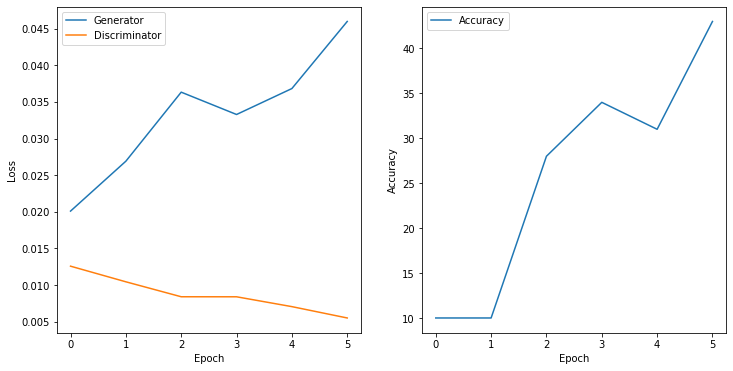

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.4359


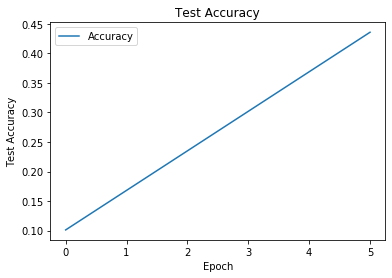

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 6/100] [D loss: 0.004961, acc: 56%] [G loss: 0.051275]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 7/100] [D loss: 0.004636, acc: 56%] [G loss: 0.053559]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 8/100] [D loss: 0.004428, acc: 67%] [G loss: 0.055938]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 9/100] [D loss: 0.004309, acc: 70%] [G loss: 0.059262]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 10/100] [D loss: 0.003617, acc: 62%] [G loss: 0.062224]


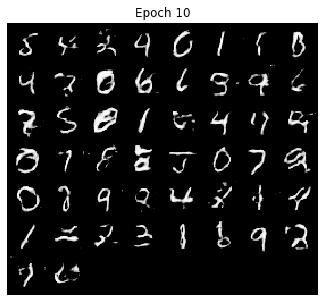

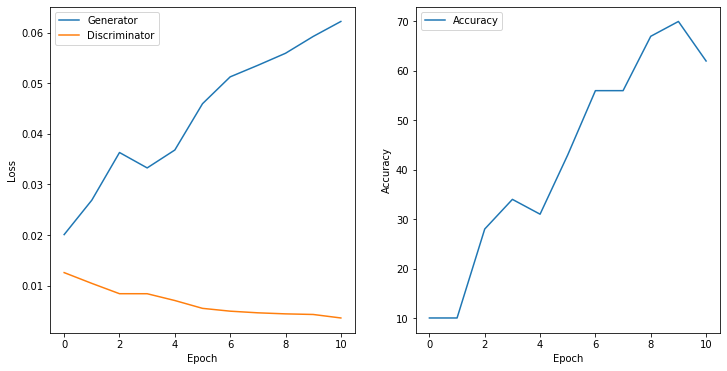

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.5352


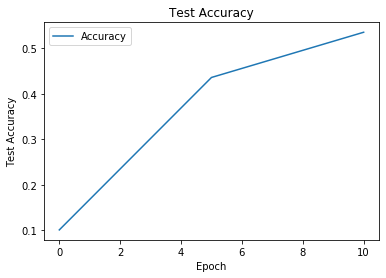

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 11/100] [D loss: 0.003689, acc: 66%] [G loss: 0.065956]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 12/100] [D loss: 0.003317, acc: 74%] [G loss: 0.070334]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 13/100] [D loss: 0.003333, acc: 75%] [G loss: 0.072663]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 14/100] [D loss: 0.002306, acc: 78%] [G loss: 0.081631]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 15/100] [D loss: 0.002668, acc: 66%] [G loss: 0.088663]


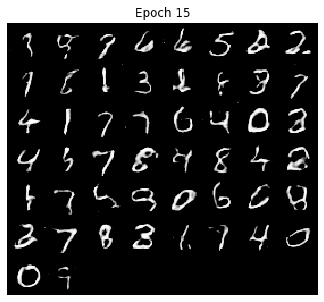

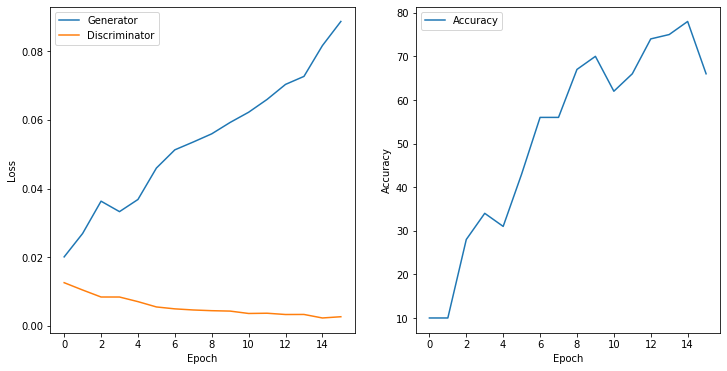

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.594


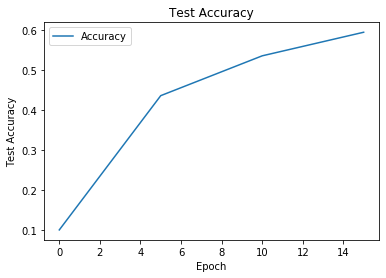

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 16/100] [D loss: 0.002054, acc: 74%] [G loss: 0.092253]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 17/100] [D loss: 0.002294, acc: 79%] [G loss: 0.096795]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 18/100] [D loss: 0.001967, acc: 80%] [G loss: 0.100025]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 19/100] [D loss: 0.001747, acc: 75%] [G loss: 0.104365]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 20/100] [D loss: 0.001383, acc: 84%] [G loss: 0.112802]


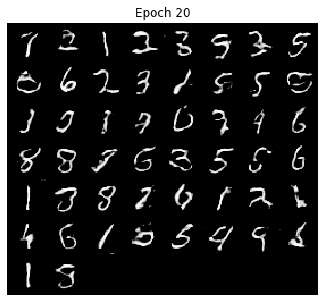

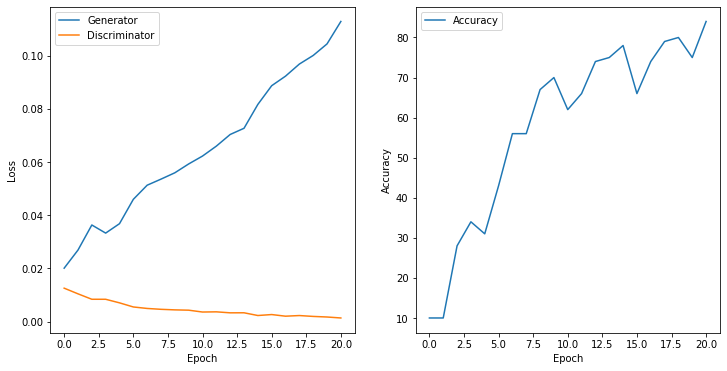

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6572


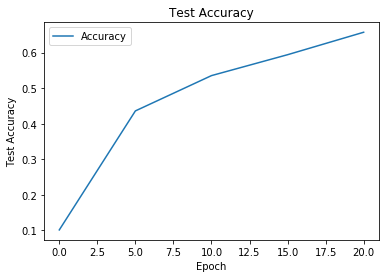

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 21/100] [D loss: 0.001532, acc: 79%] [G loss: 0.114388]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 22/100] [D loss: 0.001452, acc: 79%] [G loss: 0.117579]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 23/100] [D loss: 0.001420, acc: 85%] [G loss: 0.124855]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 24/100] [D loss: 0.001371, acc: 82%] [G loss: 0.124892]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 25/100] [D loss: 0.001011, acc: 84%] [G loss: 0.129002]


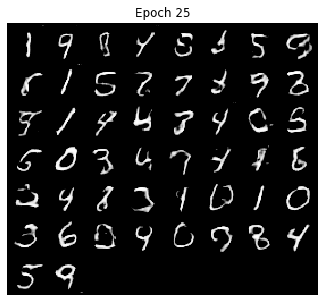

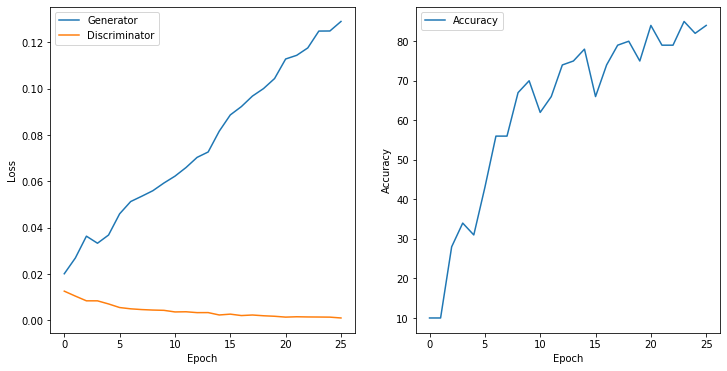

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6117999999999999


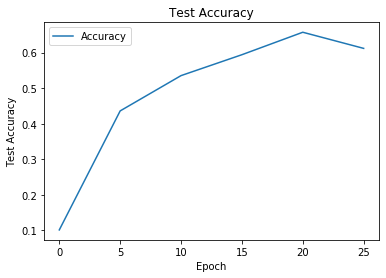

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 26/100] [D loss: 0.001169, acc: 77%] [G loss: 0.137630]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 27/100] [D loss: 0.001392, acc: 84%] [G loss: 0.135844]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 28/100] [D loss: 0.000952, acc: 83%] [G loss: 0.137982]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 29/100] [D loss: 0.001089, acc: 81%] [G loss: 0.144119]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 30/100] [D loss: 0.000817, acc: 86%] [G loss: 0.147753]


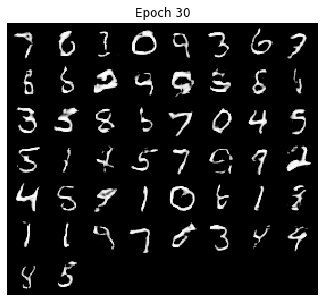

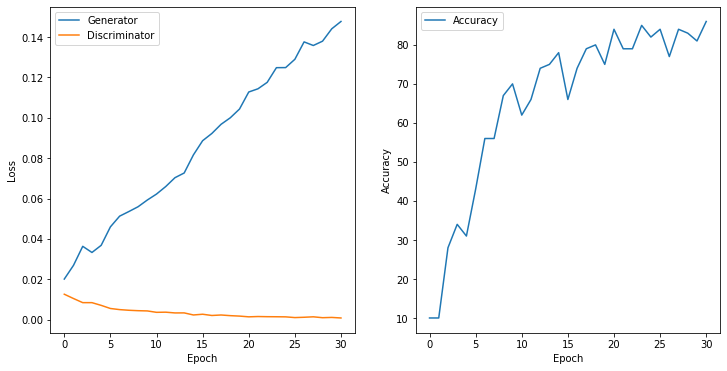

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6994999999999999


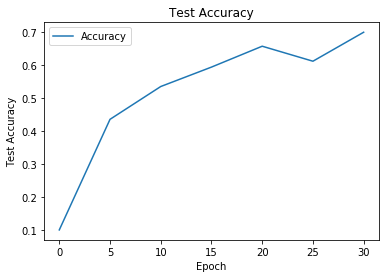

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 31/100] [D loss: 0.000838, acc: 84%] [G loss: 0.148523]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 32/100] [D loss: 0.000811, acc: 86%] [G loss: 0.147861]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 33/100] [D loss: 0.000689, acc: 79%] [G loss: 0.153736]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 34/100] [D loss: 0.000674, acc: 81%] [G loss: 0.156154]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 35/100] [D loss: 0.001077, acc: 86%] [G loss: 0.153915]


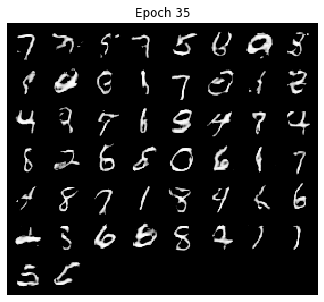

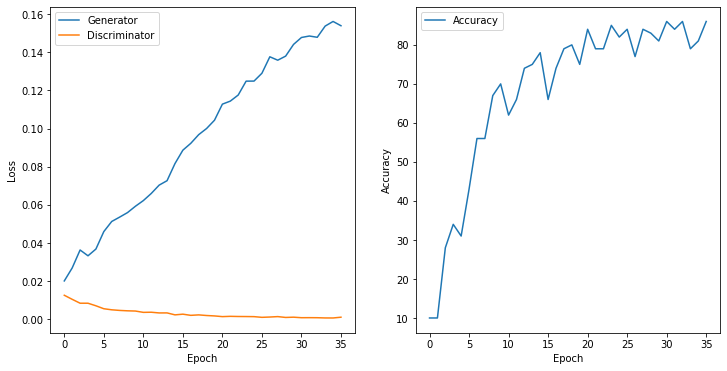

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6950999999999999


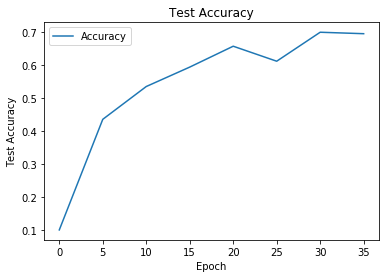

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 36/100] [D loss: 0.000674, acc: 84%] [G loss: 0.162603]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 37/100] [D loss: 0.000657, acc: 85%] [G loss: 0.167197]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 38/100] [D loss: 0.000850, acc: 85%] [G loss: 0.165001]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 39/100] [D loss: 0.000422, acc: 87%] [G loss: 0.173588]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 40/100] [D loss: 0.000468, acc: 83%] [G loss: 0.176753]


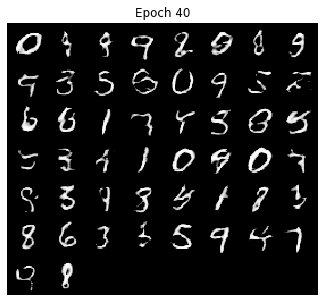

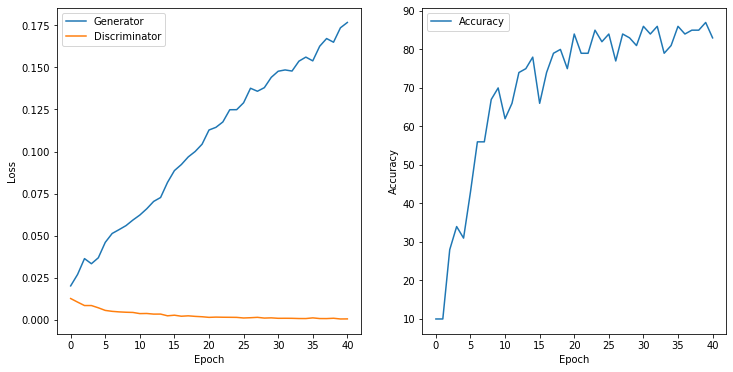

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7055000000000001


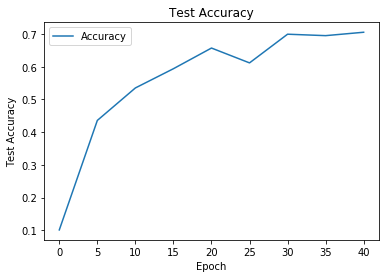

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 41/100] [D loss: 0.000850, acc: 88%] [G loss: 0.167350]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 42/100] [D loss: 0.000476, acc: 87%] [G loss: 0.182753]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 43/100] [D loss: 0.000634, acc: 85%] [G loss: 0.170580]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 44/100] [D loss: 0.000795, acc: 88%] [G loss: 0.177270]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 45/100] [D loss: 0.000591, acc: 88%] [G loss: 0.173513]


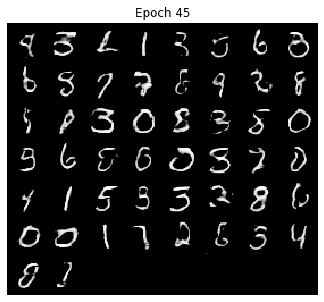

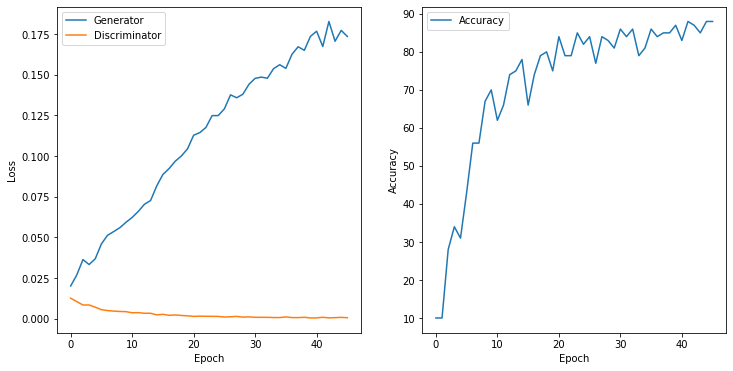

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6929


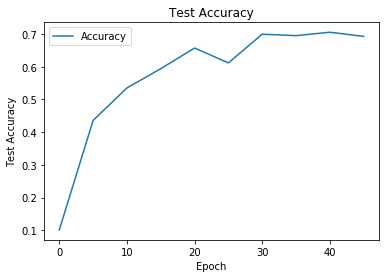

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 46/100] [D loss: 0.000463, acc: 79%] [G loss: 0.175460]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 47/100] [D loss: 0.000662, acc: 85%] [G loss: 0.175282]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 48/100] [D loss: 0.000554, acc: 87%] [G loss: 0.176859]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 49/100] [D loss: 0.000691, acc: 88%] [G loss: 0.173584]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 50/100] [D loss: 0.000399, acc: 84%] [G loss: 0.179232]


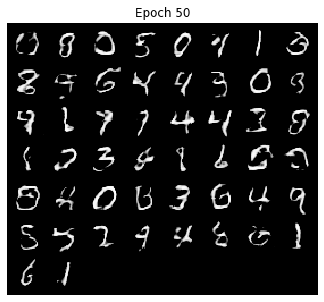

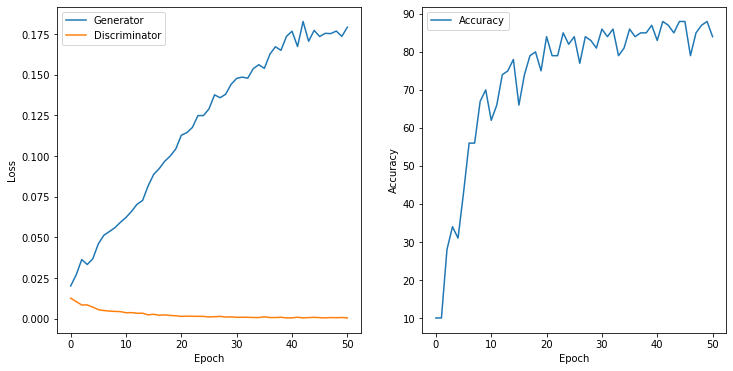

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7225


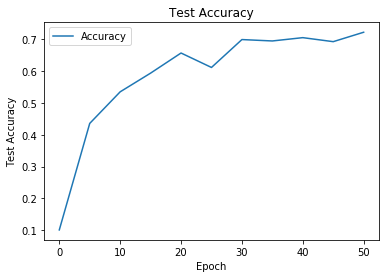

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 51/100] [D loss: 0.000722, acc: 84%] [G loss: 0.177961]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 52/100] [D loss: 0.000516, acc: 84%] [G loss: 0.185931]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 53/100] [D loss: 0.000500, acc: 84%] [G loss: 0.190230]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 54/100] [D loss: 0.000839, acc: 79%] [G loss: 0.180669]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 55/100] [D loss: 0.000446, acc: 90%] [G loss: 0.190700]


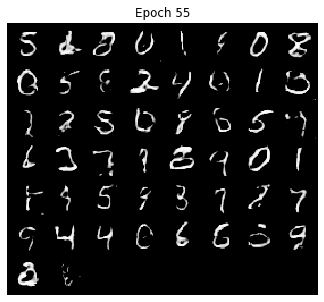

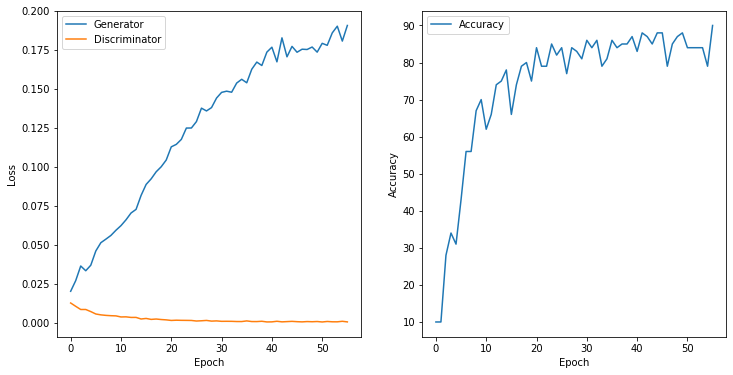

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7137


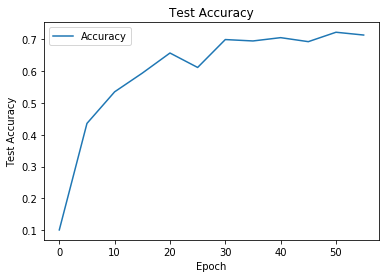

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 56/100] [D loss: 0.000770, acc: 89%] [G loss: 0.187706]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 57/100] [D loss: 0.000239, acc: 86%] [G loss: 0.188775]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 58/100] [D loss: 0.000533, acc: 86%] [G loss: 0.188684]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 59/100] [D loss: 0.000653, acc: 89%] [G loss: 0.187275]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 60/100] [D loss: 0.000638, acc: 90%] [G loss: 0.192274]


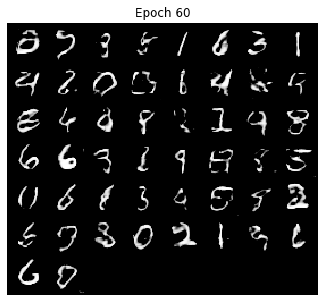

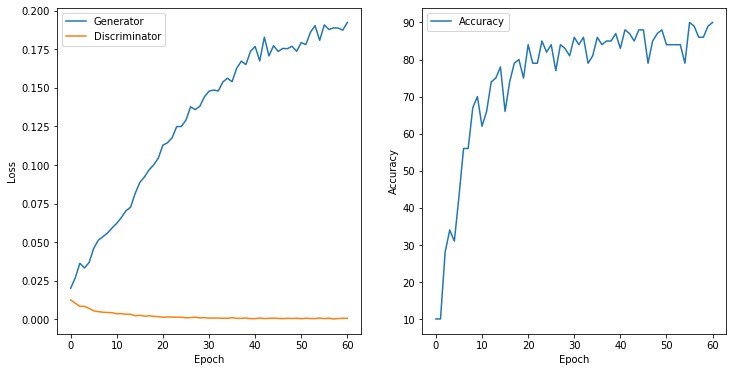

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7121


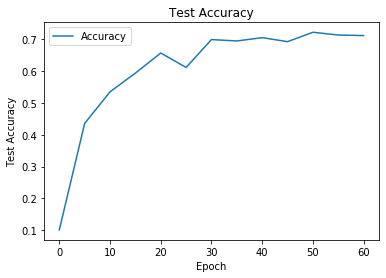

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 61/100] [D loss: 0.000342, acc: 88%] [G loss: 0.188969]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 62/100] [D loss: 0.000566, acc: 92%] [G loss: 0.187869]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 63/100] [D loss: 0.000770, acc: 88%] [G loss: 0.191562]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 64/100] [D loss: 0.000587, acc: 90%] [G loss: 0.186027]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 65/100] [D loss: 0.000670, acc: 91%] [G loss: 0.188836]


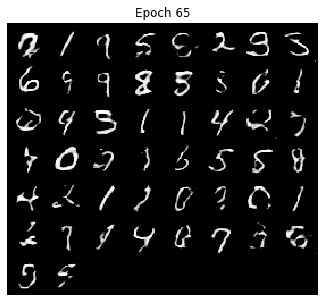

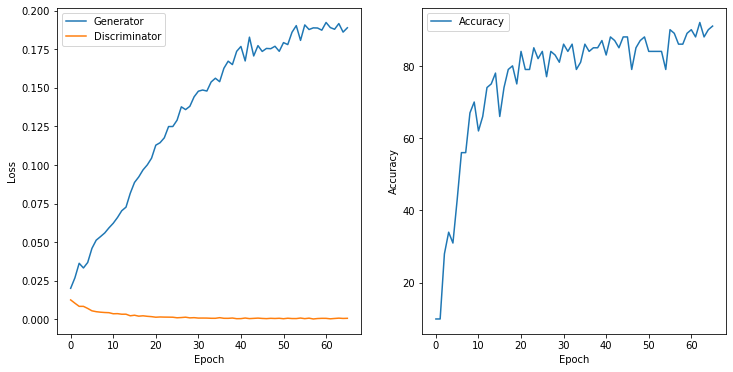

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6863999999999999


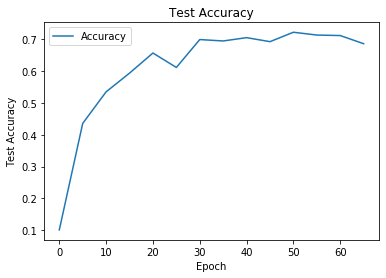

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 66/100] [D loss: 0.000381, acc: 92%] [G loss: 0.195942]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 67/100] [D loss: 0.000483, acc: 86%] [G loss: 0.194737]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 68/100] [D loss: 0.001022, acc: 87%] [G loss: 0.177491]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 69/100] [D loss: 0.000618, acc: 84%] [G loss: 0.177004]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 70/100] [D loss: 0.000550, acc: 89%] [G loss: 0.175583]


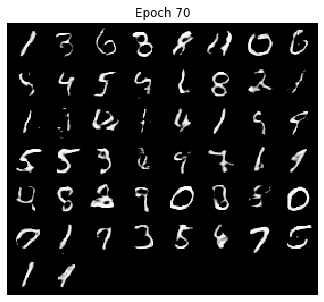

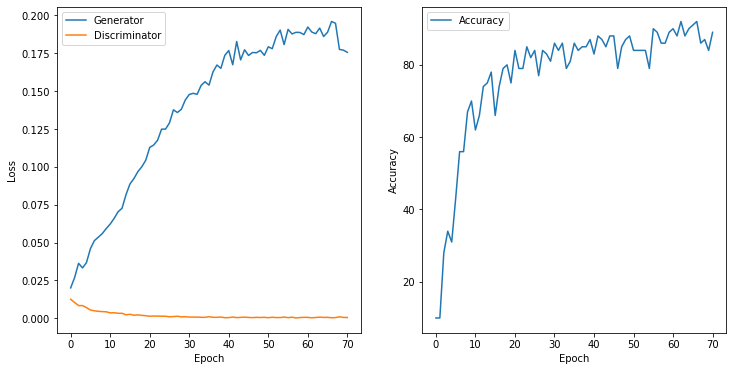

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7289


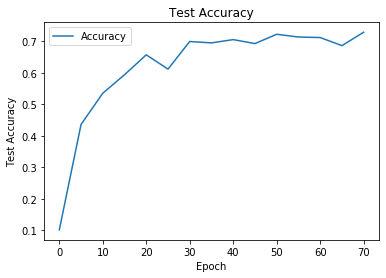

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 71/100] [D loss: 0.000656, acc: 93%] [G loss: 0.190364]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 72/100] [D loss: 0.000546, acc: 89%] [G loss: 0.185911]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 73/100] [D loss: 0.000669, acc: 88%] [G loss: 0.186923]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 74/100] [D loss: 0.000232, acc: 89%] [G loss: 0.196652]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 75/100] [D loss: 0.001280, acc: 86%] [G loss: 0.185191]


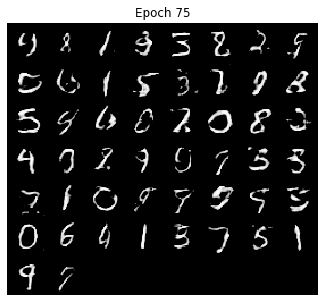

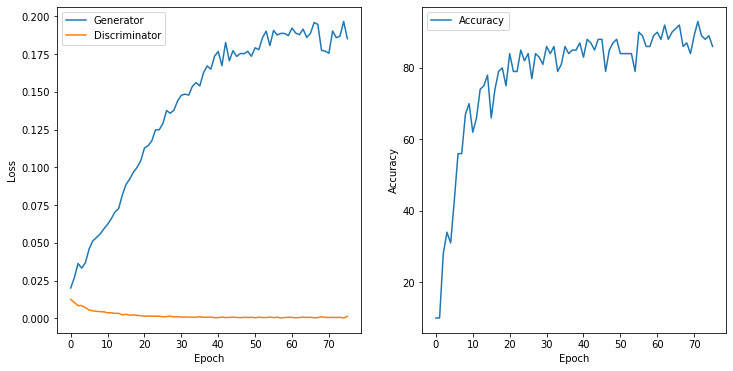

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7091999999999998


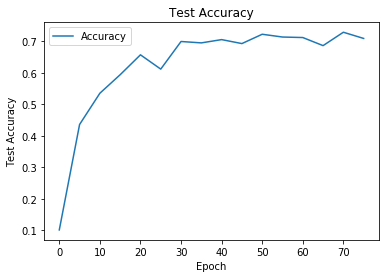

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 76/100] [D loss: 0.000454, acc: 88%] [G loss: 0.188814]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 77/100] [D loss: 0.000612, acc: 91%] [G loss: 0.188309]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 78/100] [D loss: 0.000403, acc: 87%] [G loss: 0.185735]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 79/100] [D loss: 0.000481, acc: 89%] [G loss: 0.194898]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 80/100] [D loss: 0.000595, acc: 87%] [G loss: 0.199250]


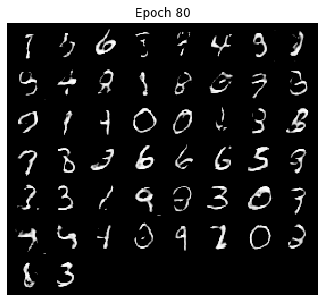

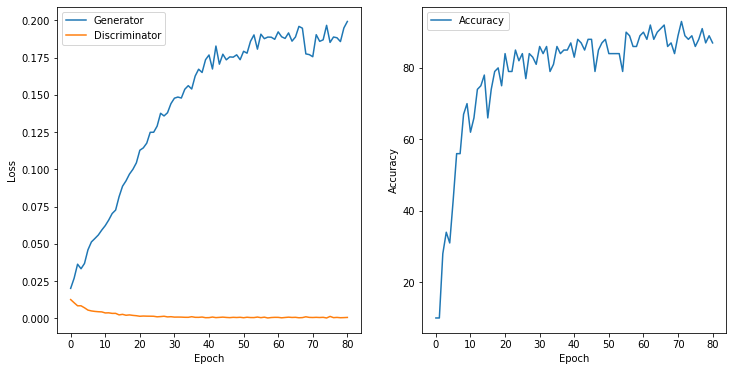

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7166


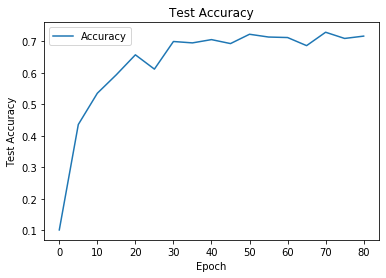

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 81/100] [D loss: 0.000723, acc: 85%] [G loss: 0.189959]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 82/100] [D loss: 0.000808, acc: 91%] [G loss: 0.189376]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 83/100] [D loss: 0.000249, acc: 86%] [G loss: 0.205130]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 84/100] [D loss: 0.000647, acc: 90%] [G loss: 0.197373]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 85/100] [D loss: 0.000373, acc: 88%] [G loss: 0.202497]


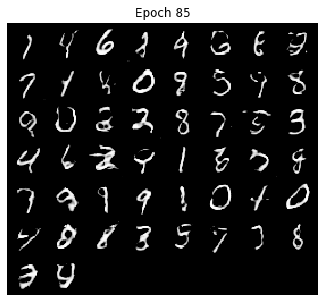

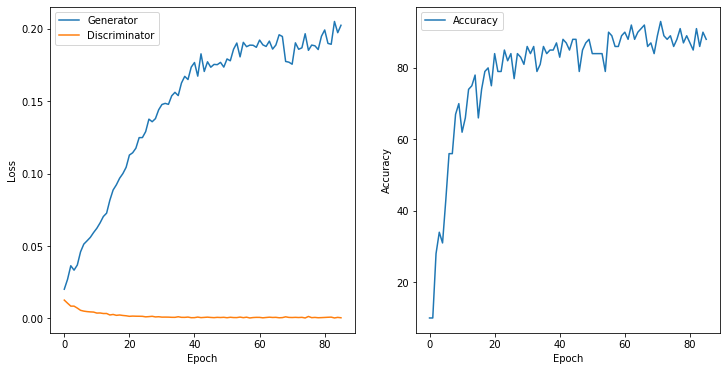

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7038


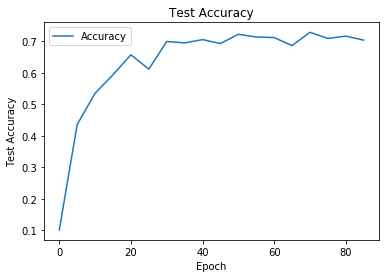

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 86/100] [D loss: 0.000542, acc: 87%] [G loss: 0.192033]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 87/100] [D loss: 0.000445, acc: 91%] [G loss: 0.199255]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 88/100] [D loss: 0.000614, acc: 89%] [G loss: 0.187203]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 89/100] [D loss: 0.000396, acc: 91%] [G loss: 0.199284]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 90/100] [D loss: 0.000355, acc: 88%] [G loss: 0.194337]


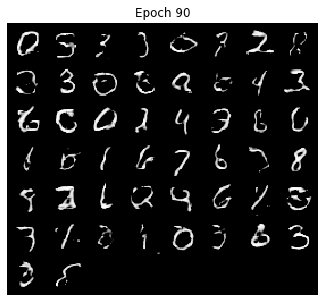

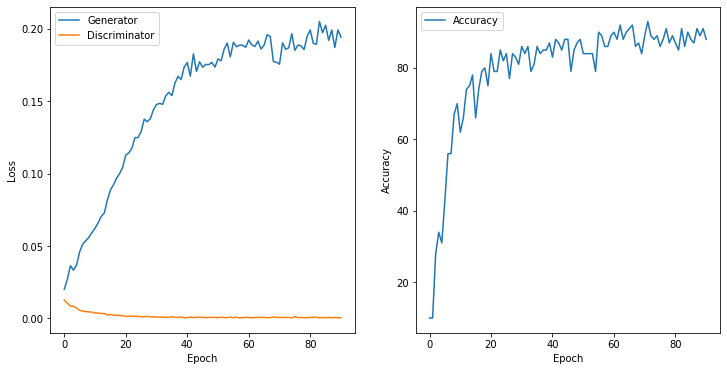

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7103


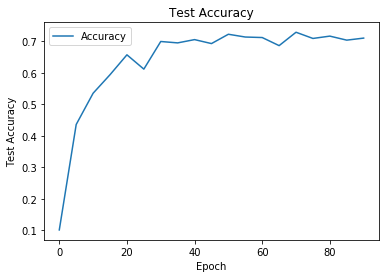

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 91/100] [D loss: 0.000574, acc: 86%] [G loss: 0.201415]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 92/100] [D loss: 0.000537, acc: 85%] [G loss: 0.195855]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 93/100] [D loss: 0.000475, acc: 85%] [G loss: 0.199648]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 94/100] [D loss: 0.000526, acc: 85%] [G loss: 0.204672]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 95/100] [D loss: 0.000547, acc: 90%] [G loss: 0.195738]


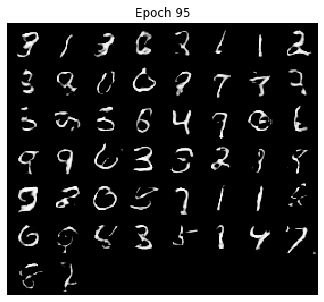

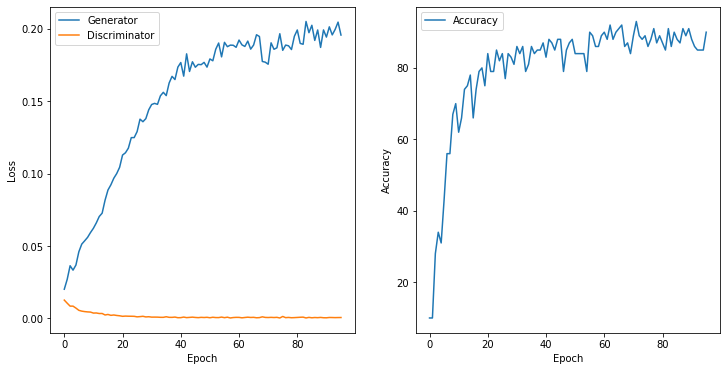

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7255000000000001


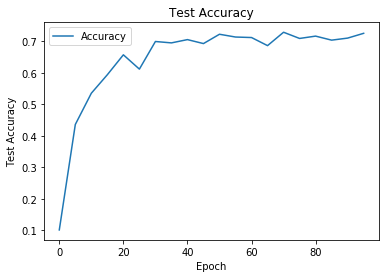

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 96/100] [D loss: 0.000534, acc: 86%] [G loss: 0.200994]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 97/100] [D loss: 0.000572, acc: 89%] [G loss: 0.191087]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 98/100] [D loss: 0.000683, acc: 87%] [G loss: 0.203311]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 99/100] [D loss: 0.000569, acc: 85%] [G loss: 0.195688]


In [12]:
def plot_loss(G_losses, D_losses, accs):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_images(imgs, epoch):
    plt.subplots(figsize=(7, 5))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.imshow(make_grid(imgs[:BATCH_SIZE].cpu(), nrow=8).permute(1, 2, 0).clamp(0,1))
    plt.show()
    
def plot_acc(accs, test_epochs):
    plt.plot(test_epochs, accs, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy")
    plt.legend()
    plt.show()
    
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()
adversarial_loss.cuda()
auxiliary_loss.cuda()
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

# ----------
#  Training
# ----------

g_losses, d_losses, accs, test_accs, test_epochs = [], [], [], [], []
EPOCHS = 100
total = 0
for epoch in tqdm(range(EPOCHS)):
    g_loss_accumulated = 0.0
    d_loss_accumulated = 0.0
    acc_accumulated = []
    total = 0
    for i, (imgs, labels) in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
#         if i >= 5: # 100 good
#             break
        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
        fake_aux_gt = Variable(LongTensor(batch_size).fill_(10), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        validity, _ = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        if i > 1:
            d_real_loss = adversarial_loss(real_pred, valid)
        else:
            d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        if i > -1:
            d_fake_loss = adversarial_loss(fake_pred, fake)
        else:
            d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, fake_aux_gt)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
#         pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
#         gt = np.concatenate([labels.data.cpu().numpy(), fake_aux_gt.data.cpu().numpy()], axis=0)
        if i < 2:  
            pred = real_aux.data.cpu().numpy()
            gt = labels.data.cpu().numpy()
            d_acc = np.mean(np.argmax(pred[:, :10], axis=1) == gt)
            acc_accumulated.append(100 * d_acc)

        d_loss.backward()
        optimizer_D.step()
        g_loss_accumulated += g_loss.item()
        d_loss_accumulated += d_loss.item()
        
        total += batch_size

    print(
        "[Epoch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
        % (epoch, EPOCHS, d_loss_accumulated / total, np.mean(acc_accumulated), g_loss_accumulated / total)
    )
    
    accs.append(np.mean(acc_accumulated))
    g_losses.append(g_loss_accumulated / total) 
    d_losses.append(d_loss_accumulated / total)
    
    if epoch % 5 == 0:
#             save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
        plot_images(gen_imgs, epoch)
        plot_loss(g_losses, d_losses, accs)
        test_accs.append(evaluate(discriminator))
        test_epochs.append(epoch)
        plot_acc(test_accs, test_epochs)

In [13]:
evaluate(discriminator)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7286


0.7286

# 3) Classifier

  0%|          | 0/200 [00:00<?, ?it/s]

[Epoch 0/200] [D loss: 0.047946, acc: 11%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.17130000000000004


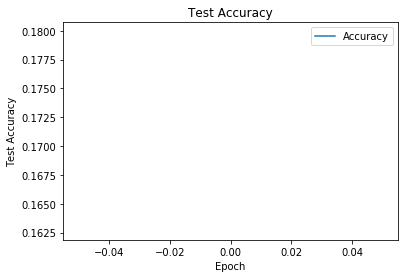

[Epoch 1/200] [D loss: 0.047914, acc: 22%]
[Epoch 2/200] [D loss: 0.047876, acc: 27%]
[Epoch 3/200] [D loss: 0.047818, acc: 37%]
[Epoch 4/200] [D loss: 0.047717, acc: 47%]
[Epoch 5/200] [D loss: 0.047579, acc: 44%]
[Epoch 6/200] [D loss: 0.047270, acc: 45%]
[Epoch 7/200] [D loss: 0.046923, acc: 40%]
[Epoch 8/200] [D loss: 0.046110, acc: 43%]
[Epoch 9/200] [D loss: 0.045236, acc: 38%]
[Epoch 10/200] [D loss: 0.044201, acc: 38%]
[Epoch 11/200] [D loss: 0.043357, acc: 42%]
[Epoch 12/200] [D loss: 0.042632, acc: 48%]
[Epoch 13/200] [D loss: 0.041448, acc: 51%]
[Epoch 14/200] [D loss: 0.040640, acc: 54%]
[Epoch 15/200] [D loss: 0.040769, acc: 58%]
[Epoch 16/200] [D loss: 0.039377, acc: 63%]
[Epoch 17/200] [D loss: 0.038450, acc: 66%]
[Epoch 18/200] [D loss: 0.037786, acc: 71%]
[Epoch 19/200] [D loss: 0.037319, acc: 73%]
[Epoch 20/200] [D loss: 0.036622, acc: 81%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.5654


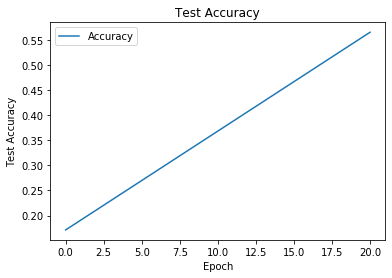

[Epoch 21/200] [D loss: 0.036126, acc: 83%]
[Epoch 22/200] [D loss: 0.035788, acc: 82%]
[Epoch 23/200] [D loss: 0.035614, acc: 83%]
[Epoch 24/200] [D loss: 0.035335, acc: 85%]
[Epoch 25/200] [D loss: 0.035112, acc: 86%]
[Epoch 26/200] [D loss: 0.034737, acc: 86%]
[Epoch 27/200] [D loss: 0.034495, acc: 86%]
[Epoch 28/200] [D loss: 0.034165, acc: 88%]
[Epoch 29/200] [D loss: 0.034020, acc: 90%]
[Epoch 30/200] [D loss: 0.033941, acc: 88%]
[Epoch 31/200] [D loss: 0.033920, acc: 88%]
[Epoch 32/200] [D loss: 0.033403, acc: 90%]
[Epoch 33/200] [D loss: 0.033275, acc: 90%]
[Epoch 34/200] [D loss: 0.032936, acc: 93%]
[Epoch 35/200] [D loss: 0.033120, acc: 92%]
[Epoch 36/200] [D loss: 0.033046, acc: 92%]
[Epoch 37/200] [D loss: 0.032469, acc: 94%]
[Epoch 38/200] [D loss: 0.032616, acc: 95%]
[Epoch 39/200] [D loss: 0.032387, acc: 96%]
[Epoch 40/200] [D loss: 0.032564, acc: 95%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6683


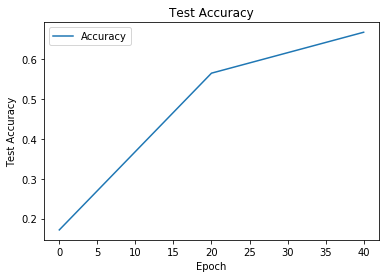

[Epoch 41/200] [D loss: 0.032126, acc: 96%]
[Epoch 42/200] [D loss: 0.032240, acc: 95%]
[Epoch 43/200] [D loss: 0.031958, acc: 96%]
[Epoch 44/200] [D loss: 0.031979, acc: 96%]
[Epoch 45/200] [D loss: 0.032008, acc: 96%]
[Epoch 46/200] [D loss: 0.031869, acc: 96%]
[Epoch 47/200] [D loss: 0.031934, acc: 96%]
[Epoch 48/200] [D loss: 0.032014, acc: 96%]
[Epoch 49/200] [D loss: 0.031955, acc: 96%]
[Epoch 50/200] [D loss: 0.031689, acc: 97%]
[Epoch 51/200] [D loss: 0.031652, acc: 97%]
[Epoch 52/200] [D loss: 0.031669, acc: 97%]
[Epoch 53/200] [D loss: 0.031675, acc: 97%]
[Epoch 54/200] [D loss: 0.031654, acc: 97%]
[Epoch 55/200] [D loss: 0.031583, acc: 97%]
[Epoch 56/200] [D loss: 0.031526, acc: 98%]
[Epoch 57/200] [D loss: 0.031635, acc: 98%]
[Epoch 58/200] [D loss: 0.031484, acc: 99%]
[Epoch 59/200] [D loss: 0.031403, acc: 98%]
[Epoch 60/200] [D loss: 0.031581, acc: 98%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6937000000000001


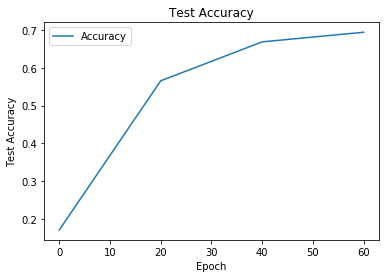

[Epoch 61/200] [D loss: 0.031339, acc: 98%]
[Epoch 62/200] [D loss: 0.031194, acc: 99%]
[Epoch 63/200] [D loss: 0.031288, acc: 99%]
[Epoch 64/200] [D loss: 0.031351, acc: 99%]
[Epoch 65/200] [D loss: 0.031213, acc: 99%]
[Epoch 66/200] [D loss: 0.031396, acc: 99%]
[Epoch 67/200] [D loss: 0.031250, acc: 99%]
[Epoch 68/200] [D loss: 0.031217, acc: 99%]
[Epoch 69/200] [D loss: 0.031168, acc: 99%]
[Epoch 70/200] [D loss: 0.031257, acc: 99%]
[Epoch 71/200] [D loss: 0.031189, acc: 99%]
[Epoch 72/200] [D loss: 0.031154, acc: 99%]
[Epoch 73/200] [D loss: 0.031159, acc: 99%]
[Epoch 74/200] [D loss: 0.031185, acc: 99%]
[Epoch 75/200] [D loss: 0.031142, acc: 99%]
[Epoch 76/200] [D loss: 0.031128, acc: 99%]
[Epoch 77/200] [D loss: 0.031149, acc: 99%]
[Epoch 78/200] [D loss: 0.031201, acc: 99%]
[Epoch 79/200] [D loss: 0.031121, acc: 99%]
[Epoch 80/200] [D loss: 0.031205, acc: 99%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6878


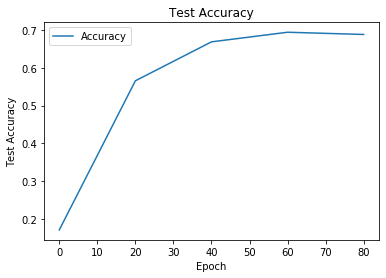

[Epoch 81/200] [D loss: 0.031194, acc: 99%]
[Epoch 82/200] [D loss: 0.031150, acc: 99%]
[Epoch 83/200] [D loss: 0.031192, acc: 99%]
[Epoch 84/200] [D loss: 0.031130, acc: 99%]
[Epoch 85/200] [D loss: 0.031151, acc: 99%]
[Epoch 86/200] [D loss: 0.031135, acc: 99%]
[Epoch 87/200] [D loss: 0.031165, acc: 99%]
[Epoch 88/200] [D loss: 0.031151, acc: 99%]
[Epoch 89/200] [D loss: 0.031136, acc: 99%]
[Epoch 90/200] [D loss: 0.031114, acc: 99%]
[Epoch 91/200] [D loss: 0.031133, acc: 99%]
[Epoch 92/200] [D loss: 0.031121, acc: 99%]
[Epoch 93/200] [D loss: 0.031113, acc: 99%]
[Epoch 94/200] [D loss: 0.031130, acc: 99%]
[Epoch 95/200] [D loss: 0.031127, acc: 99%]
[Epoch 96/200] [D loss: 0.031088, acc: 99%]
[Epoch 97/200] [D loss: 0.031126, acc: 99%]
[Epoch 98/200] [D loss: 0.031113, acc: 99%]
[Epoch 99/200] [D loss: 0.031103, acc: 99%]
[Epoch 100/200] [D loss: 0.031101, acc: 99%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6937000000000001


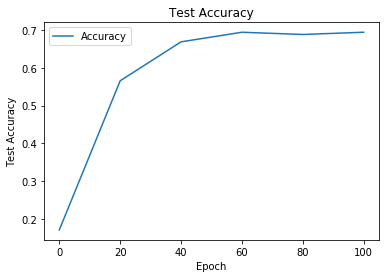

[Epoch 101/200] [D loss: 0.031116, acc: 99%]
[Epoch 102/200] [D loss: 0.031113, acc: 99%]
[Epoch 103/200] [D loss: 0.031122, acc: 99%]
[Epoch 104/200] [D loss: 0.031083, acc: 99%]
[Epoch 105/200] [D loss: 0.031124, acc: 99%]
[Epoch 106/200] [D loss: 0.031257, acc: 99%]
[Epoch 107/200] [D loss: 0.031089, acc: 99%]
[Epoch 108/200] [D loss: 0.031092, acc: 99%]
[Epoch 109/200] [D loss: 0.031089, acc: 99%]
[Epoch 110/200] [D loss: 0.031125, acc: 99%]
[Epoch 111/200] [D loss: 0.031095, acc: 99%]
[Epoch 112/200] [D loss: 0.031102, acc: 99%]
[Epoch 113/200] [D loss: 0.031100, acc: 99%]
[Epoch 114/200] [D loss: 0.031087, acc: 99%]
[Epoch 115/200] [D loss: 0.031081, acc: 99%]
[Epoch 116/200] [D loss: 0.031116, acc: 99%]
[Epoch 117/200] [D loss: 0.031081, acc: 99%]
[Epoch 118/200] [D loss: 0.031096, acc: 99%]
[Epoch 119/200] [D loss: 0.031100, acc: 99%]
[Epoch 120/200] [D loss: 0.031111, acc: 99%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6931


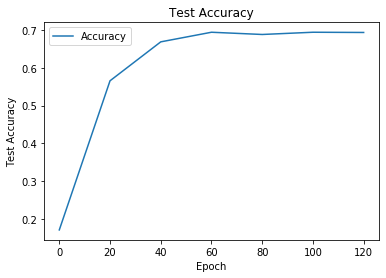

[Epoch 121/200] [D loss: 0.031118, acc: 99%]
[Epoch 122/200] [D loss: 0.031086, acc: 99%]
[Epoch 123/200] [D loss: 0.031104, acc: 99%]
[Epoch 124/200] [D loss: 0.031093, acc: 99%]
[Epoch 125/200] [D loss: 0.031079, acc: 99%]
[Epoch 126/200] [D loss: 0.031087, acc: 99%]
[Epoch 127/200] [D loss: 0.031114, acc: 99%]
[Epoch 128/200] [D loss: 0.031100, acc: 99%]
[Epoch 129/200] [D loss: 0.031117, acc: 99%]
[Epoch 130/200] [D loss: 0.031091, acc: 99%]
[Epoch 131/200] [D loss: 0.031085, acc: 99%]
[Epoch 132/200] [D loss: 0.031121, acc: 99%]
[Epoch 133/200] [D loss: 0.031113, acc: 99%]
[Epoch 134/200] [D loss: 0.031074, acc: 99%]
[Epoch 135/200] [D loss: 0.031074, acc: 99%]
[Epoch 136/200] [D loss: 0.031087, acc: 99%]
[Epoch 137/200] [D loss: 0.031089, acc: 99%]
[Epoch 138/200] [D loss: 0.031097, acc: 99%]
[Epoch 139/200] [D loss: 0.031093, acc: 99%]
[Epoch 140/200] [D loss: 0.031083, acc: 99%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6965


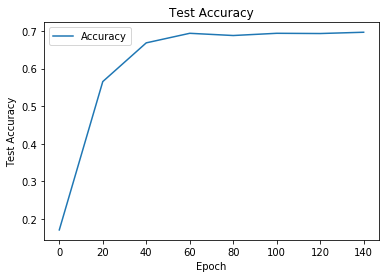

[Epoch 141/200] [D loss: 0.031087, acc: 99%]
[Epoch 142/200] [D loss: 0.031082, acc: 99%]
[Epoch 143/200] [D loss: 0.031111, acc: 99%]
[Epoch 144/200] [D loss: 0.031079, acc: 99%]
[Epoch 145/200] [D loss: 0.031080, acc: 99%]
[Epoch 146/200] [D loss: 0.031086, acc: 99%]
[Epoch 147/200] [D loss: 0.031076, acc: 99%]
[Epoch 148/200] [D loss: 0.031091, acc: 99%]
[Epoch 149/200] [D loss: 0.031089, acc: 99%]
[Epoch 150/200] [D loss: 0.031078, acc: 99%]
[Epoch 151/200] [D loss: 0.031161, acc: 99%]
[Epoch 152/200] [D loss: 0.031072, acc: 99%]
[Epoch 153/200] [D loss: 0.031073, acc: 99%]
[Epoch 154/200] [D loss: 0.031083, acc: 99%]
[Epoch 155/200] [D loss: 0.031076, acc: 99%]
[Epoch 156/200] [D loss: 0.031099, acc: 99%]
[Epoch 157/200] [D loss: 0.031068, acc: 99%]
[Epoch 158/200] [D loss: 0.031076, acc: 99%]
[Epoch 159/200] [D loss: 0.031083, acc: 99%]
[Epoch 160/200] [D loss: 0.031080, acc: 99%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6908


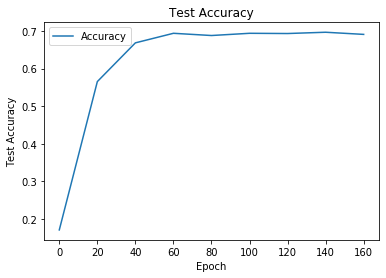

[Epoch 161/200] [D loss: 0.031068, acc: 99%]
[Epoch 162/200] [D loss: 0.031066, acc: 99%]
[Epoch 163/200] [D loss: 0.031065, acc: 99%]
[Epoch 164/200] [D loss: 0.031086, acc: 99%]
[Epoch 165/200] [D loss: 0.031081, acc: 99%]
[Epoch 166/200] [D loss: 0.031082, acc: 99%]
[Epoch 167/200] [D loss: 0.031085, acc: 99%]
[Epoch 168/200] [D loss: 0.031079, acc: 99%]
[Epoch 169/200] [D loss: 0.031071, acc: 99%]
[Epoch 170/200] [D loss: 0.031087, acc: 99%]
[Epoch 171/200] [D loss: 0.031071, acc: 99%]
[Epoch 172/200] [D loss: 0.031095, acc: 99%]
[Epoch 173/200] [D loss: 0.031065, acc: 99%]
[Epoch 174/200] [D loss: 0.031078, acc: 99%]
[Epoch 175/200] [D loss: 0.031074, acc: 99%]
[Epoch 176/200] [D loss: 0.031068, acc: 99%]
[Epoch 177/200] [D loss: 0.031074, acc: 99%]
[Epoch 178/200] [D loss: 0.031077, acc: 99%]
[Epoch 179/200] [D loss: 0.031074, acc: 99%]
[Epoch 180/200] [D loss: 0.031082, acc: 99%]


  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.691


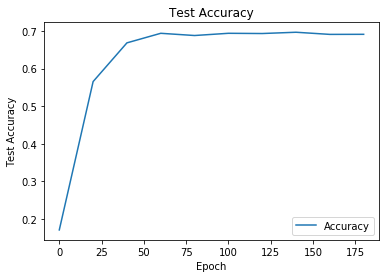

[Epoch 181/200] [D loss: 0.031106, acc: 99%]
[Epoch 182/200] [D loss: 0.031067, acc: 99%]
[Epoch 183/200] [D loss: 0.031077, acc: 99%]
[Epoch 184/200] [D loss: 0.031067, acc: 99%]
[Epoch 185/200] [D loss: 0.031073, acc: 99%]
[Epoch 186/200] [D loss: 0.031063, acc: 99%]
[Epoch 187/200] [D loss: 0.031076, acc: 99%]
[Epoch 188/200] [D loss: 0.031064, acc: 99%]
[Epoch 189/200] [D loss: 0.031075, acc: 99%]
[Epoch 190/200] [D loss: 0.031065, acc: 99%]
[Epoch 191/200] [D loss: 0.031066, acc: 99%]
[Epoch 192/200] [D loss: 0.031073, acc: 99%]
[Epoch 193/200] [D loss: 0.031065, acc: 99%]
[Epoch 194/200] [D loss: 0.031051, acc: 99%]
[Epoch 195/200] [D loss: 0.031077, acc: 99%]
[Epoch 196/200] [D loss: 0.031075, acc: 99%]
[Epoch 197/200] [D loss: 0.031056, acc: 99%]
[Epoch 198/200] [D loss: 0.031068, acc: 99%]
[Epoch 199/200] [D loss: 0.031049, acc: 99%]


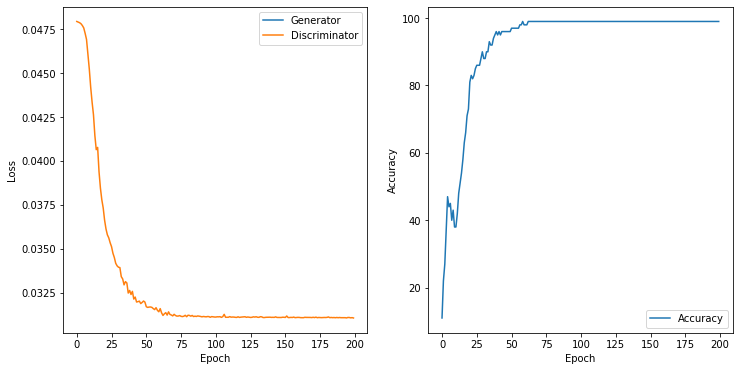

In [16]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
d_classifier = Discriminator()

d_classifier.cuda()
adversarial_loss.cuda()
auxiliary_loss.cuda()
    
# Optimizers
optimizer_D = torch.optim.Adam(d_classifier.parameters(), lr=0.001)

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

# ----------
#  Training
# ----------

d_losses, accs, test_accs, test_epochs = [], [], [], []
EPOCHS = 200
total = 0
for epoch in tqdm(range(EPOCHS)):
    d_loss_accumulated = 0.0
    acc_accumulated = []
    total = 0
    for i, (imgs, labels) in enumerate(dataloader, 0):
        if i > 1:
            break
        batch_size = imgs.shape[0]
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        # Loss for real images
        real_pred, real_aux = d_classifier(real_imgs)
        d_real_loss = auxiliary_loss(real_aux, labels)

        # Total discriminator loss
        d_loss = d_real_loss

        # Calculate discriminator accuracy
        pred = real_aux.data.cpu().numpy()
        gt = labels.data.cpu().numpy()
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optimizer_D.step()

        d_loss_accumulated += d_loss.item()
        acc_accumulated.append(100 * d_acc)
        total += batch_size

    print(
        "[Epoch %d/%d] [D loss: %f, acc: %d%%]"
        % (epoch, EPOCHS, d_loss_accumulated / total, np.mean(acc_accumulated))
    )
    
    accs.append(np.mean(acc_accumulated))
    d_losses.append(d_loss_accumulated / total)
    if epoch % 20 == 0:
        test_accs.append(evaluate(d_classifier))
        test_epochs.append(epoch)
        plot_acc(test_accs, test_epochs)
#         plot_loss([], d_losses, accs)
plot_loss([], d_losses, accs)

In [17]:
evaluate(d_classifier)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6995


0.6995

# 4) VAE

In [52]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=4):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to("cuda")
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dims=4):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, 5, stride=1),
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    
class VAE(nn.Module):
    def __init__(self, latent_dims=4):
        super(VAE, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to('cuda')
#         print(x.shape)
        z = self.encoder(x)
#         print(z.shape)
        d = self.decoder(z)
#         print(d.shape)
        return d

In [53]:
vae = VAE().to("cuda")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 0/100] [D loss: 0.000174, acc: 12%] [G loss: 936.353551]


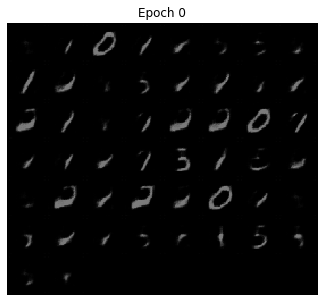

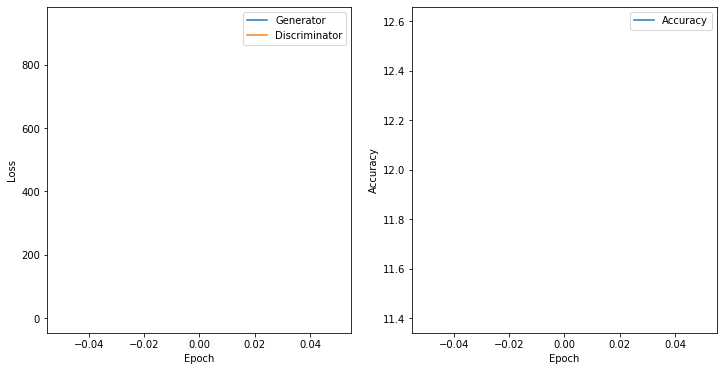

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.10100000000000002


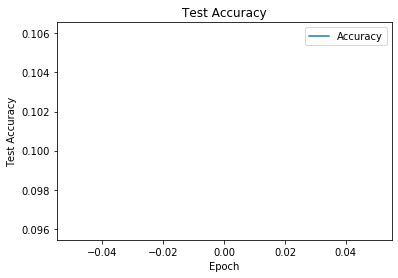

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 1/100] [D loss: 0.000020, acc: 9%] [G loss: 888.129444]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 2/100] [D loss: 0.000019, acc: 22%] [G loss: 884.406931]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 3/100] [D loss: 0.000019, acc: 31%] [G loss: 881.793502]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 4/100] [D loss: 0.000019, acc: 29%] [G loss: 879.808230]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 5/100] [D loss: 0.000019, acc: 25%] [G loss: 878.574092]


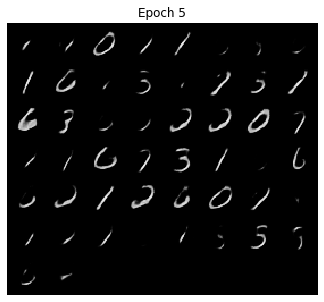

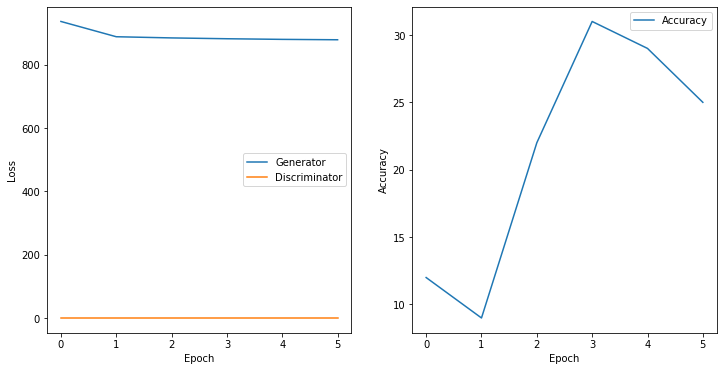

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.1822


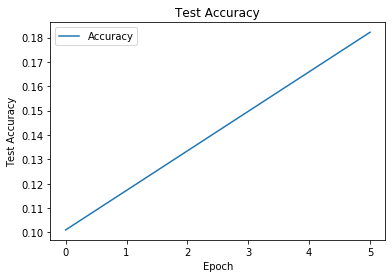

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 6/100] [D loss: 0.000019, acc: 24%] [G loss: 877.772618]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 7/100] [D loss: 0.000019, acc: 30%] [G loss: 877.306484]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 8/100] [D loss: 0.000019, acc: 32%] [G loss: 876.897039]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 9/100] [D loss: 0.000017, acc: 46%] [G loss: 876.606922]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 10/100] [D loss: 0.000018, acc: 36%] [G loss: 876.352673]


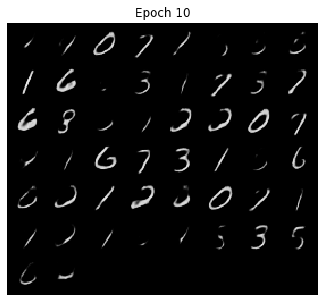

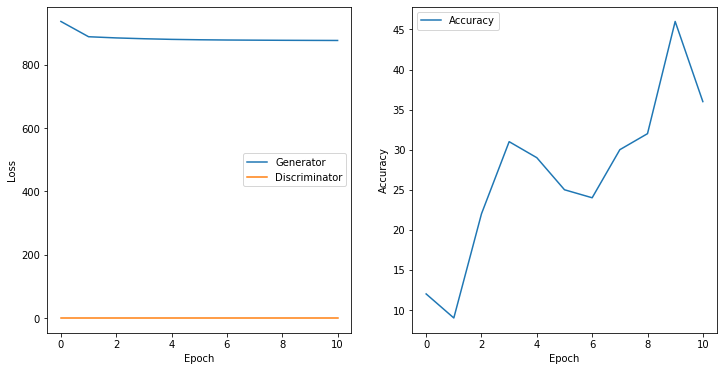

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.3666


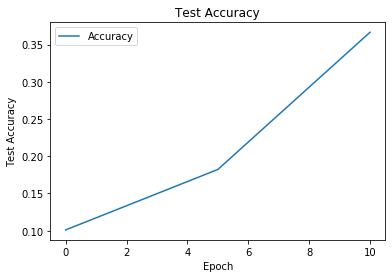

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 11/100] [D loss: 0.000017, acc: 50%] [G loss: 876.233514]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 12/100] [D loss: 0.000017, acc: 46%] [G loss: 875.975061]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 13/100] [D loss: 0.000016, acc: 57%] [G loss: 875.986424]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 14/100] [D loss: 0.000017, acc: 54%] [G loss: 875.747532]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 15/100] [D loss: 0.000016, acc: 64%] [G loss: 875.596316]


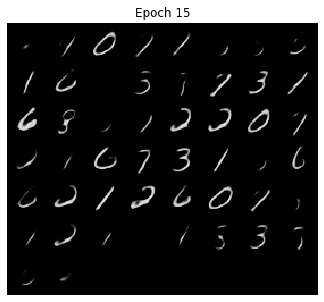

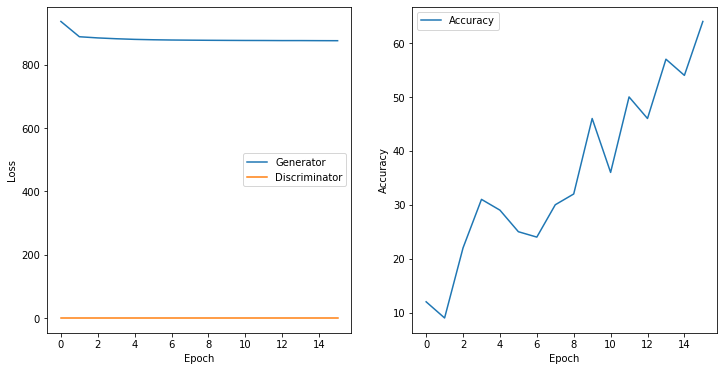

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.4468


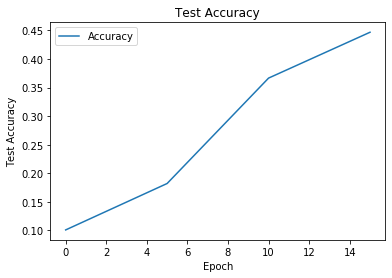

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 16/100] [D loss: 0.000016, acc: 61%] [G loss: 875.414248]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 17/100] [D loss: 0.000016, acc: 65%] [G loss: 875.376021]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 18/100] [D loss: 0.000016, acc: 61%] [G loss: 875.195068]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 19/100] [D loss: 0.000016, acc: 64%] [G loss: 875.093847]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 20/100] [D loss: 0.000016, acc: 57%] [G loss: 874.956357]


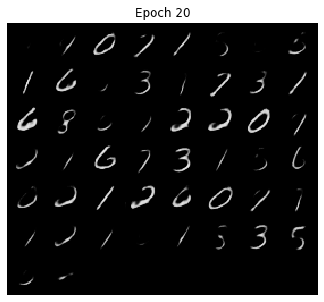

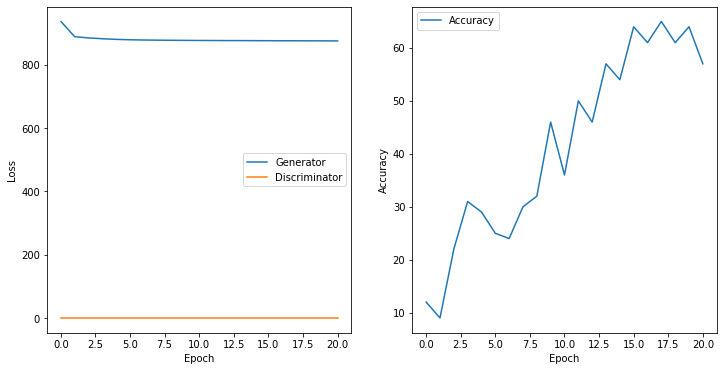

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.46180000000000004


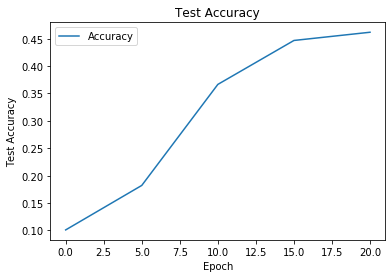

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 21/100] [D loss: 0.000016, acc: 64%] [G loss: 874.869992]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 22/100] [D loss: 0.000015, acc: 68%] [G loss: 874.826077]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 23/100] [D loss: 0.000017, acc: 69%] [G loss: 874.891685]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 24/100] [D loss: 0.000015, acc: 70%] [G loss: 874.847353]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 25/100] [D loss: 0.000015, acc: 78%] [G loss: 874.844359]


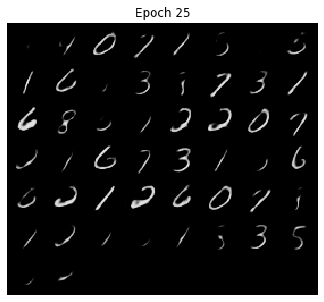

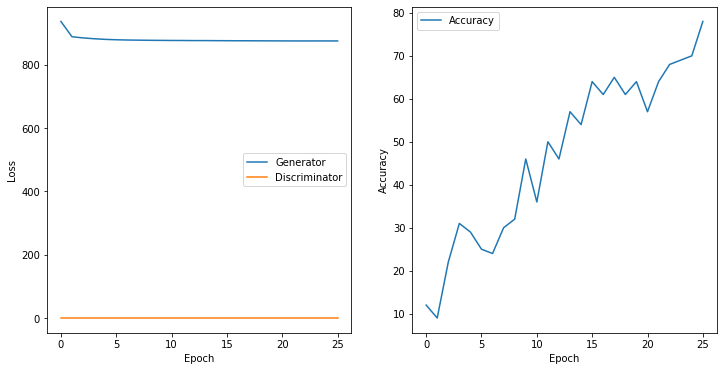

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.539


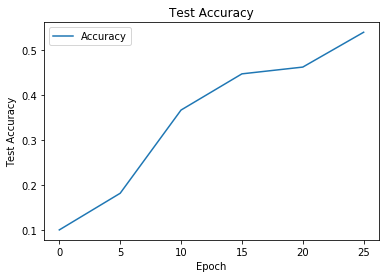

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 26/100] [D loss: 0.000015, acc: 73%] [G loss: 874.807378]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 27/100] [D loss: 0.000015, acc: 75%] [G loss: 874.743038]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 28/100] [D loss: 0.000015, acc: 77%] [G loss: 874.646856]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 29/100] [D loss: 0.000015, acc: 74%] [G loss: 874.504698]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 30/100] [D loss: 0.000014, acc: 81%] [G loss: 874.430614]


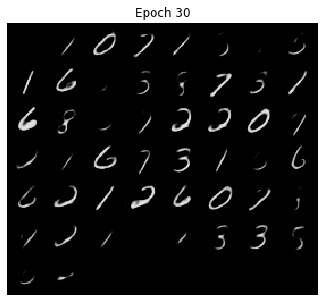

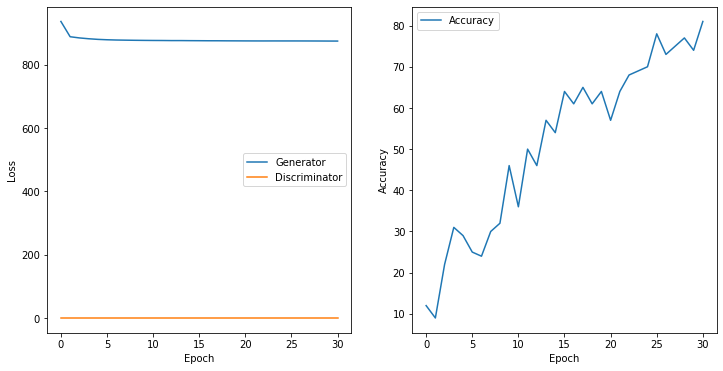

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.5869


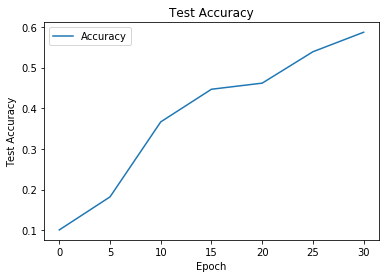

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 31/100] [D loss: 0.000015, acc: 75%] [G loss: 874.417704]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 32/100] [D loss: 0.000014, acc: 83%] [G loss: 874.315893]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 33/100] [D loss: 0.000014, acc: 89%] [G loss: 874.256230]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 34/100] [D loss: 0.000014, acc: 86%] [G loss: 874.215329]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 35/100] [D loss: 0.000014, acc: 87%] [G loss: 874.215460]


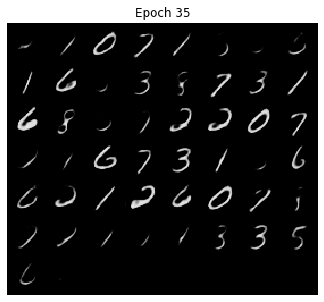

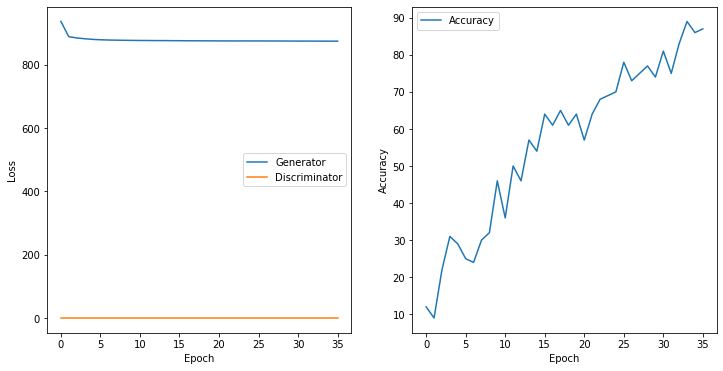

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6298


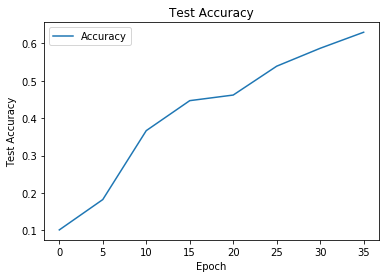

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 36/100] [D loss: 0.000014, acc: 91%] [G loss: 874.084420]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 37/100] [D loss: 0.000014, acc: 89%] [G loss: 874.163691]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 38/100] [D loss: 0.000013, acc: 93%] [G loss: 874.226996]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 39/100] [D loss: 0.000014, acc: 91%] [G loss: 874.133541]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 40/100] [D loss: 0.000014, acc: 92%] [G loss: 874.135277]


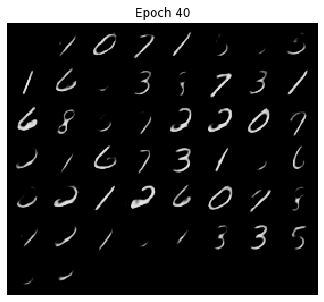

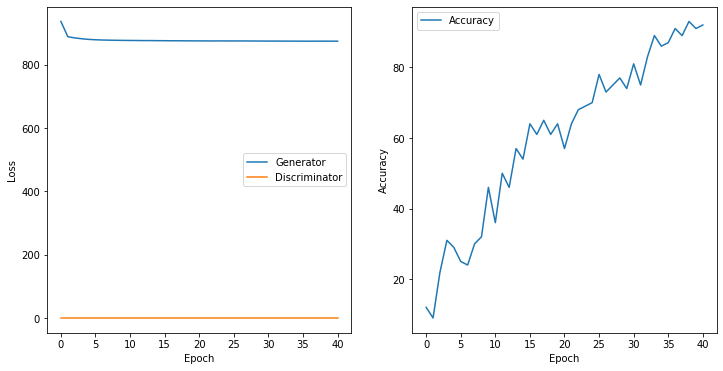

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6114


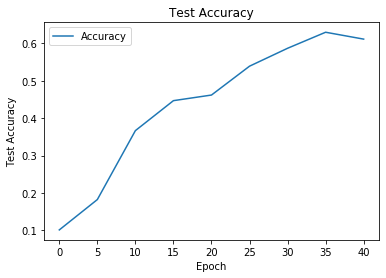

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 41/100] [D loss: 0.000014, acc: 89%] [G loss: 874.010602]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 42/100] [D loss: 0.000013, acc: 93%] [G loss: 873.964638]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 43/100] [D loss: 0.000013, acc: 95%] [G loss: 874.064478]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 44/100] [D loss: 0.000013, acc: 95%] [G loss: 874.039423]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 45/100] [D loss: 0.000014, acc: 93%] [G loss: 874.274311]


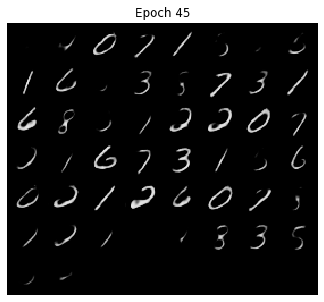

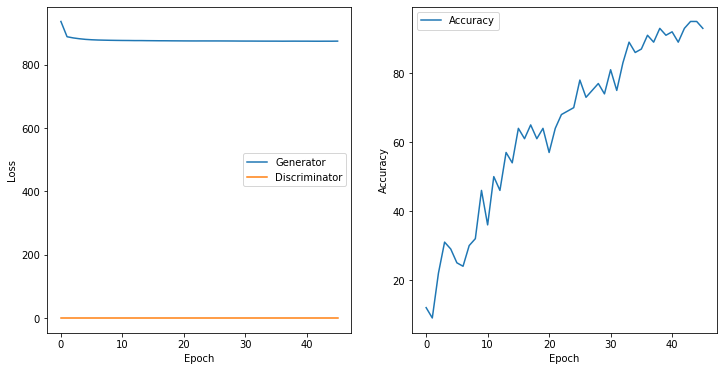

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6746000000000001


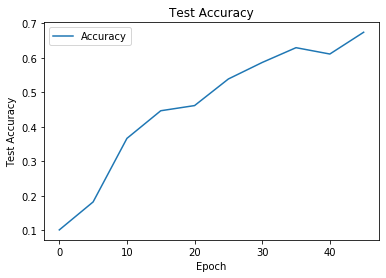

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 46/100] [D loss: 0.000014, acc: 93%] [G loss: 874.080938]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 47/100] [D loss: 0.000013, acc: 95%] [G loss: 874.020331]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 48/100] [D loss: 0.000013, acc: 95%] [G loss: 873.998144]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 49/100] [D loss: 0.000013, acc: 96%] [G loss: 873.964324]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 50/100] [D loss: 0.000013, acc: 94%] [G loss: 873.830458]


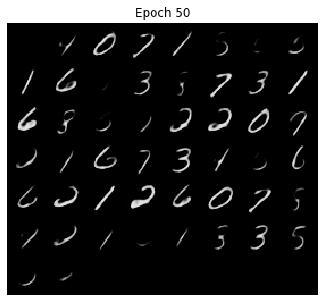

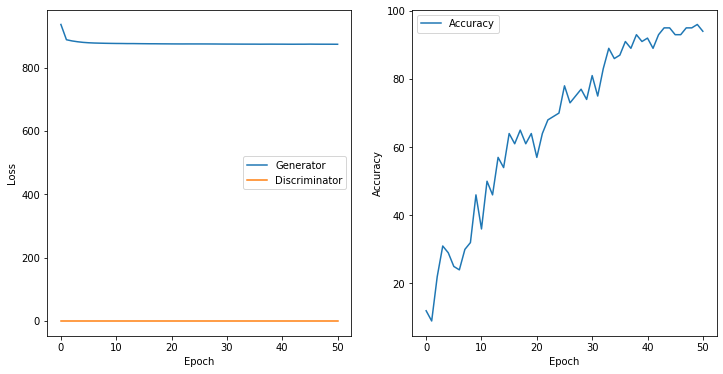

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6537999999999999


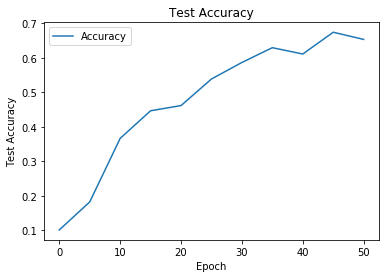

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 51/100] [D loss: 0.000013, acc: 97%] [G loss: 873.827548]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 52/100] [D loss: 0.000013, acc: 96%] [G loss: 873.766678]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 53/100] [D loss: 0.000013, acc: 97%] [G loss: 873.734902]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 54/100] [D loss: 0.000016, acc: 96%] [G loss: 874.006149]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 55/100] [D loss: 0.000013, acc: 97%] [G loss: 873.950396]


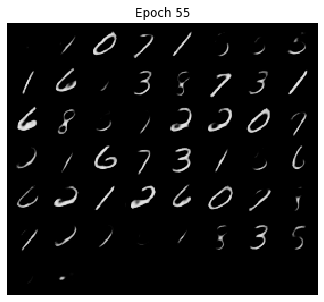

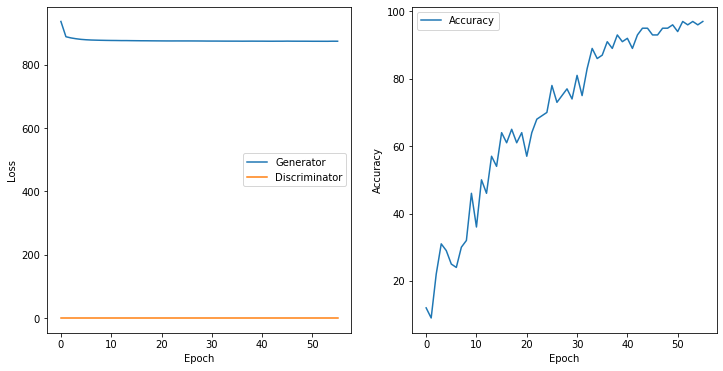

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6481999999999999


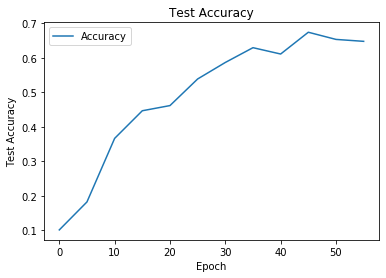

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 56/100] [D loss: 0.000013, acc: 95%] [G loss: 873.972968]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 57/100] [D loss: 0.000013, acc: 97%] [G loss: 873.900092]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 58/100] [D loss: 0.000013, acc: 98%] [G loss: 873.859063]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 59/100] [D loss: 0.000013, acc: 96%] [G loss: 873.671717]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 60/100] [D loss: 0.000013, acc: 97%] [G loss: 873.608621]


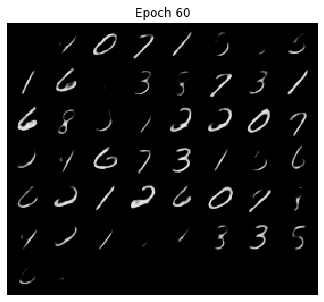

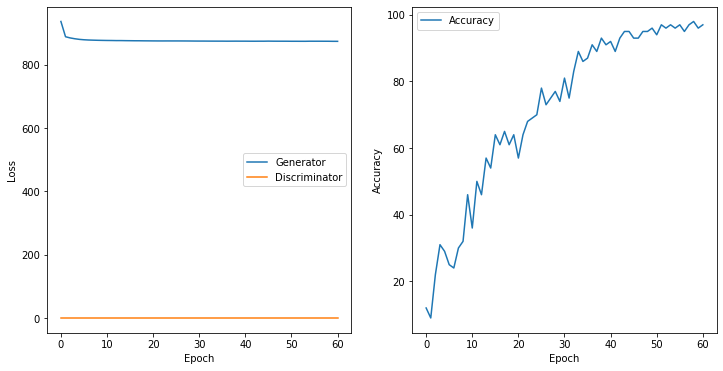

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6727


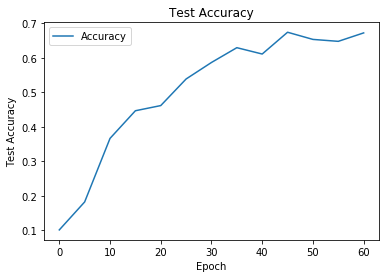

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 61/100] [D loss: 0.000013, acc: 97%] [G loss: 873.600831]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 62/100] [D loss: 0.000013, acc: 96%] [G loss: 873.569125]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 63/100] [D loss: 0.000013, acc: 98%] [G loss: 873.527287]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 64/100] [D loss: 0.000013, acc: 97%] [G loss: 873.498182]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 65/100] [D loss: 0.000013, acc: 98%] [G loss: 873.547317]


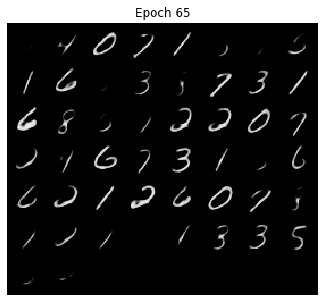

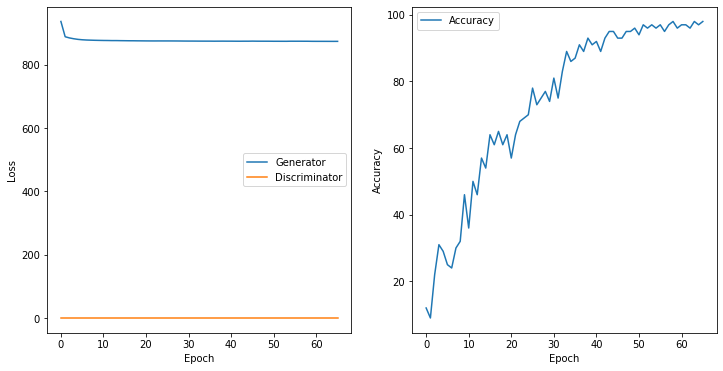

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6659999999999999


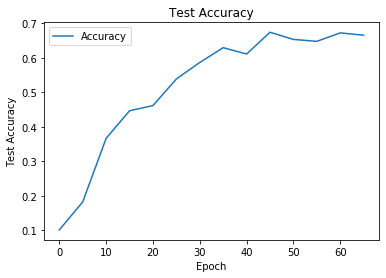

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 66/100] [D loss: 0.000013, acc: 97%] [G loss: 873.550402]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 67/100] [D loss: 0.000013, acc: 98%] [G loss: 873.585437]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 68/100] [D loss: 0.000014, acc: 89%] [G loss: 873.496548]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 69/100] [D loss: 0.000014, acc: 88%] [G loss: 873.542018]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 70/100] [D loss: 0.000013, acc: 98%] [G loss: 873.481315]


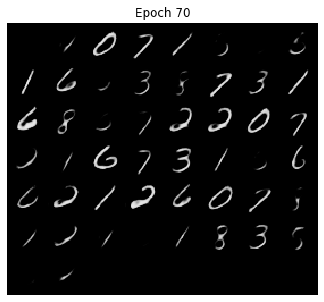

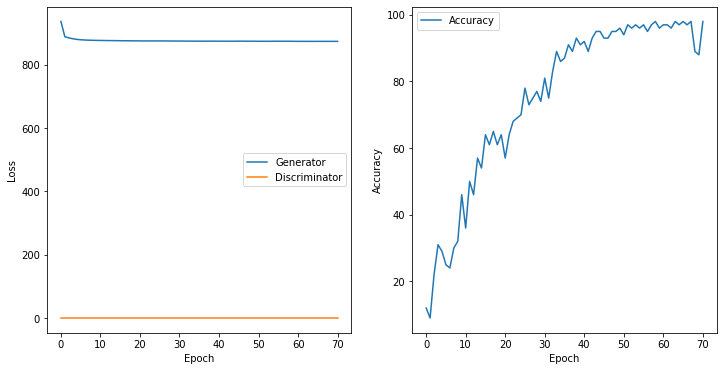

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6838999999999998


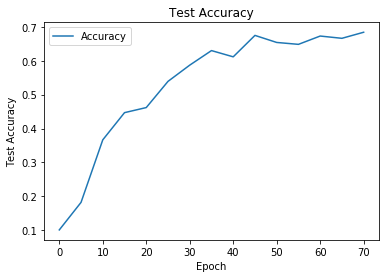

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 71/100] [D loss: 0.000013, acc: 98%] [G loss: 873.429495]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 72/100] [D loss: 0.000013, acc: 96%] [G loss: 873.456441]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 73/100] [D loss: 0.000013, acc: 98%] [G loss: 873.400200]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 74/100] [D loss: 0.000013, acc: 98%] [G loss: 873.408081]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 75/100] [D loss: 0.000013, acc: 98%] [G loss: 873.364310]


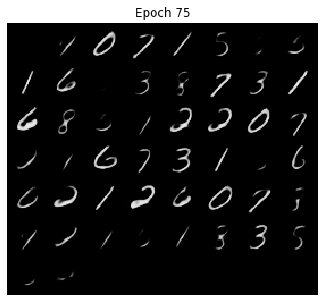

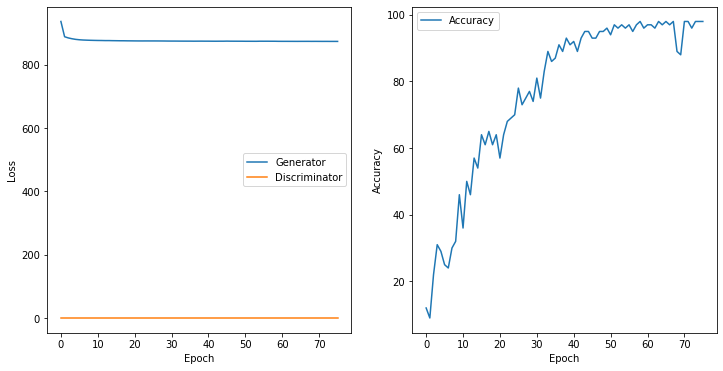

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6677


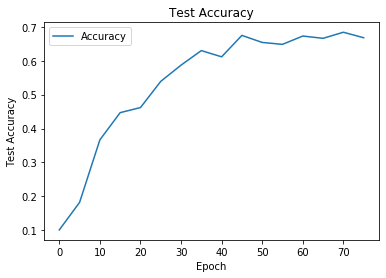

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 76/100] [D loss: 0.000013, acc: 98%] [G loss: 873.368450]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 77/100] [D loss: 0.000013, acc: 97%] [G loss: 873.397120]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 78/100] [D loss: 0.000013, acc: 96%] [G loss: 873.369523]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 79/100] [D loss: 0.000013, acc: 96%] [G loss: 873.367995]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 80/100] [D loss: 0.000013, acc: 98%] [G loss: 873.371990]


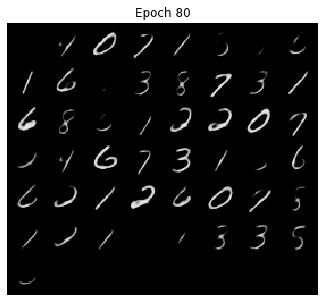

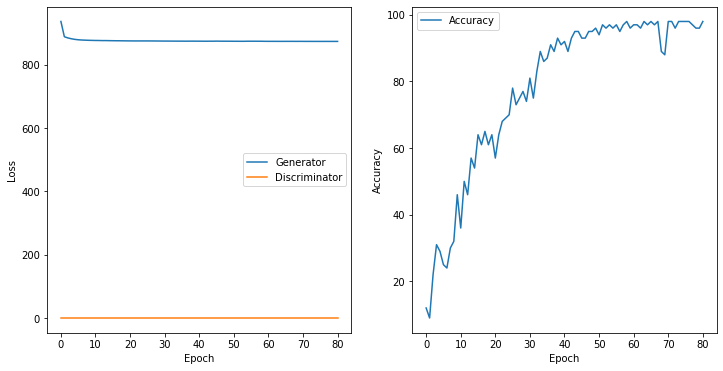

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6940000000000001


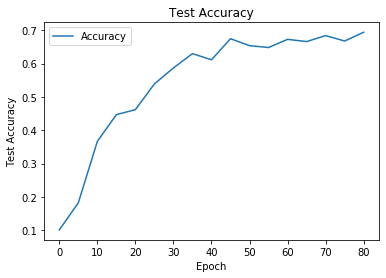

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 81/100] [D loss: 0.000013, acc: 98%] [G loss: 873.358641]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 82/100] [D loss: 0.000013, acc: 98%] [G loss: 873.324057]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 83/100] [D loss: 0.000013, acc: 96%] [G loss: 873.324569]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 84/100] [D loss: 0.000013, acc: 98%] [G loss: 873.408569]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 85/100] [D loss: 0.000013, acc: 97%] [G loss: 873.382608]


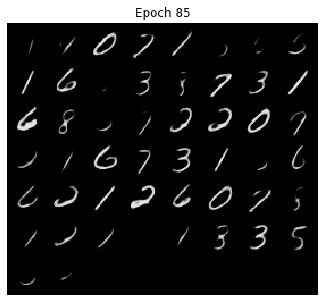

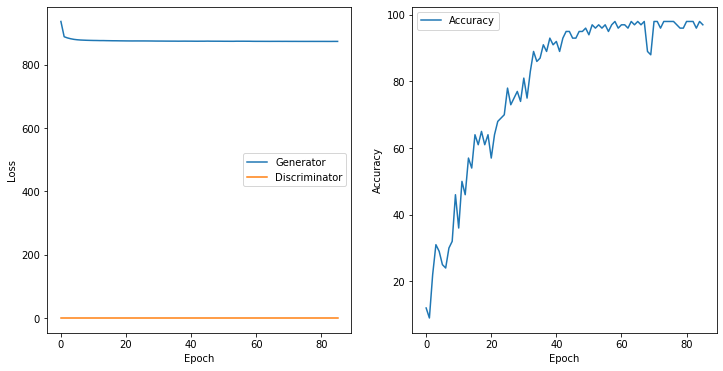

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6829


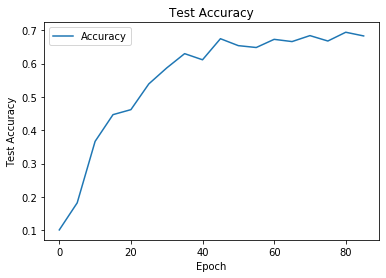

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 86/100] [D loss: 0.000013, acc: 99%] [G loss: 873.313982]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 87/100] [D loss: 0.000013, acc: 99%] [G loss: 873.274844]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 88/100] [D loss: 0.000013, acc: 99%] [G loss: 873.313368]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 89/100] [D loss: 0.000013, acc: 99%] [G loss: 873.315666]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 90/100] [D loss: 0.000013, acc: 99%] [G loss: 873.566555]


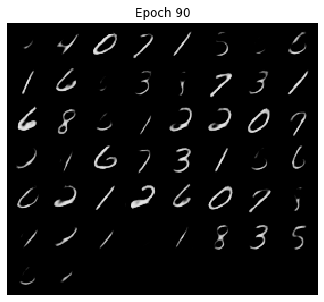

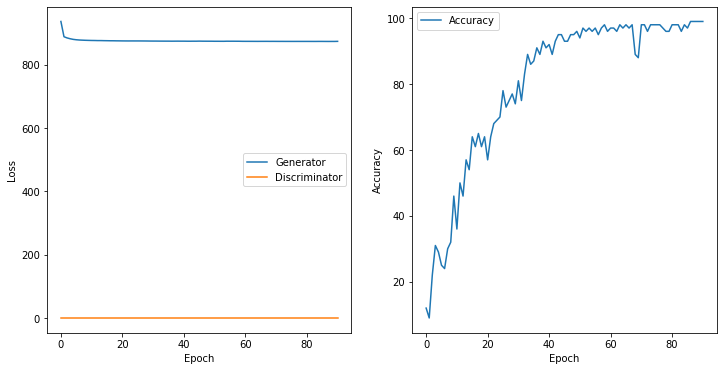

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6828


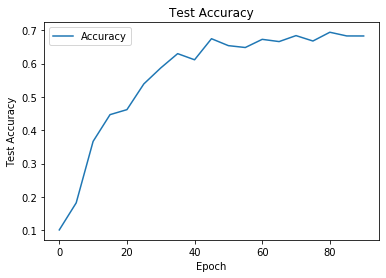

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 91/100] [D loss: 0.000013, acc: 99%] [G loss: 873.381780]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 92/100] [D loss: 0.000013, acc: 99%] [G loss: 873.334762]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 93/100] [D loss: 0.000013, acc: 97%] [G loss: 873.262027]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 94/100] [D loss: 0.000013, acc: 98%] [G loss: 873.513739]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 95/100] [D loss: 0.000013, acc: 99%] [G loss: 873.545760]


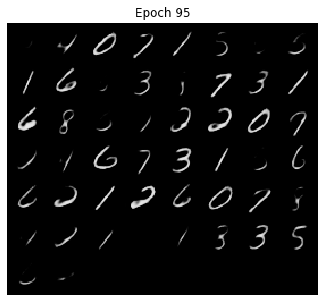

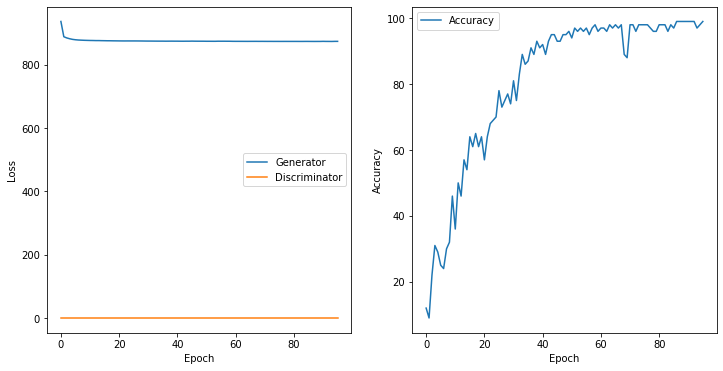

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.6972


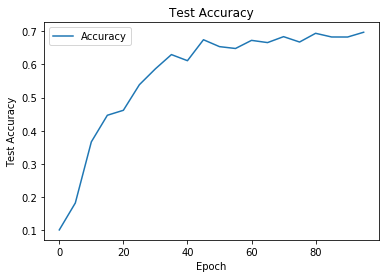

  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 96/100] [D loss: 0.000013, acc: 99%] [G loss: 873.558306]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 97/100] [D loss: 0.000013, acc: 97%] [G loss: 873.527913]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 98/100] [D loss: 0.000013, acc: 94%] [G loss: 873.472321]


  0%|          | 0/1200 [00:00<?, ?it/s]

[Epoch 99/100] [D loss: 0.000013, acc: 98%] [G loss: 873.413295]


In [54]:
def plot_loss(G_losses, D_losses, accs):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(G_losses, label="Generator")
    plt.plot(D_losses, label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_images(imgs, epoch):
    plt.subplots(figsize=(7, 5))
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.imshow(make_grid(imgs[:BATCH_SIZE].cpu(), nrow=8).permute(1, 2, 0).clamp(0,1))
    plt.show()
    
def plot_acc(accs, test_epochs):
    plt.plot(test_epochs, accs, label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy")
    plt.legend()
    plt.show()
    
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator_vae = VAE()
discriminator = Discriminator()

generator_vae.cuda()
discriminator.cuda()
adversarial_loss.cuda()
auxiliary_loss.cuda()
    
# Optimizers
optimizer_G = torch.optim.Adam(generator_vae.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

# ----------
#  Training
# ----------

g_losses, d_losses, accs, test_accs, test_epochs = [], [], [], [], []
EPOCHS = 100
total = 0
for epoch in tqdm(range(EPOCHS)):
    g_loss_accumulated = 0.0
    d_loss_accumulated = 0.0
    acc_accumulated = []
    total = 0
    for i, (imgs, labels) in tqdm(enumerate(dataloader, 0), total=len(dataloader)):
#         if i >= 5: # 100 good
#             break
        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
        fake_aux_gt = Variable(LongTensor(batch_size).fill_(10), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
#         z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, 100))))

        # Generate a batch of images
#         gen_imgs = generator(z)
        gen_imgs = generator_vae(real_imgs)
    
        # Loss measures generator's ability to fool the discriminator
        validity, _ = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        g_loss += ((gen_imgs - real_imgs)**2).sum() + generator_vae.encoder.kl
        
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs)
        if i > 1:
            d_real_loss = adversarial_loss(real_pred, valid)
        else:
            d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        if i > -1:
            d_fake_loss = adversarial_loss(fake_pred, fake)
        else:
            d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, fake_aux_gt)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
#         pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
#         gt = np.concatenate([labels.data.cpu().numpy(), fake_aux_gt.data.cpu().numpy()], axis=0)
        if i < 2:  
            pred = real_aux.data.cpu().numpy()
            gt = labels.data.cpu().numpy()
            d_acc = np.mean(np.argmax(pred[:, :10], axis=1) == gt)
            acc_accumulated.append(100 * d_acc)

        d_loss.backward()
        optimizer_D.step()
        g_loss_accumulated += g_loss.item()
        d_loss_accumulated += d_loss.item()
        
        total += batch_size

    print(
        "[Epoch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
        % (epoch, EPOCHS, d_loss_accumulated / total, np.mean(acc_accumulated), g_loss_accumulated / total)
    )
    
    accs.append(np.mean(acc_accumulated))
    g_losses.append(g_loss_accumulated / total) 
    d_losses.append(d_loss_accumulated / total)
    
    if epoch % 5 == 0:
#             save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
        plot_images(gen_imgs, epoch)
        plot_loss(g_losses, d_losses, accs)
        test_accs.append(evaluate(discriminator))
        test_epochs.append(epoch)
        plot_acc(test_accs, test_epochs)

In [55]:
evaluate(discriminator)

  0%|          | 0/200 [00:00<?, ?it/s]

Test Accuracy: 0.7039


0.7039